# Analyse the CrowdFlower results

In [ ]:
%pylab inline
import urllib2
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import sys
import json
def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f,encoding="utf-8")

#===== load df with profesion-image correspondences
df_images=pd.read_csv("profession_images_all.csv",sep='\t', encoding='utf-8',index_col=0)
df_with_image=df_images[df_images.image_link!="-"]
df_with_image_without_svg=df_with_image[~df_with_image.image_link.str.contains(".svg")]
df=df_with_image_without_svg[~df_with_image_without_svg.image_link.str.contains(".ogg|.ogv")]
print "Images without .svg and video:",len(df)-1
print "We have approx",len(df)/float(len(pd.unique(df.profession))),\
"pictures per profession with image. "+"We have",len(pd.unique(df.profession)),"professions with image."
df_unique=df[~df.duplicated('image_link')]
print "Among them ",len(df_unique), "unique images."

#===== load aggregated results:
result_old= pd.read_csv("a725997.csv", delimiter=",", header=0)#results from previous project
result= pd.read_csv("a861276_best.csv", delimiter=",", header=0)#new results

#==== load dictionary with old url to image names correspondences
old_link_name_new=load_simple_json("de/old_link_name_new.json")

Populating the interactive namespace from numpy and matplotlib
Images without .svg and video: 906
We have approx 2.62898550725 pictures per profession with image. We have 345 professions with image.
Among them  889 unique images.


In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

C:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
#combine images from old results and new results
result_old.loc[:,'no_of_persons']=result_old['no_of_persons'].str.lower().str.replace(r',|\*|\'',"").str.replace(" ","_")
result_old.loc[:,"person_plural"]=result_old["person_plural"].str.lower().str.replace(r',|\)|\(',"").str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
result_old.loc[:,"person_singular_dom"]=result_old["person_singular_dom"].str.lower().str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
result_old.loc[:,"person_singular_nondom"]=result_old["person_singular_nondom"].str.lower().str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
#result_old[(~result_old.person_plural.isnull()) ]

result.loc[:,"real_url"]=result.apply(lambda x: x["image_url"], axis = 1)
old_link_new_link={}
for link in old_link_name_new:
    j=old_link_name_new[link]
    old_link_new_link[link]=df[df.image_name==urllib2.unquote(j.replace("_"," ").encode('utf-8')).decode('utf-8')].image_link.values[0]
old_results_for_or_data=result_old[result_old.image_url.isin(old_link_name_new.keys())]#125
old_results_for_or_data.loc[:,"real_url"]=old_results_for_or_data.apply(lambda x: old_link_new_link[x["image_url"]], axis = 1)
data=pd.concat([result, old_results_for_or_data], ignore_index=True) 
#data #1049 #896-unique
#data[data._unit_state=="finalized"]#893
#data[~data.duplicated('image_url') &(data._unit_state=="finalized") ]#889
#data[(data.person_plural=="i'm_not_sure")|(data.person_singular_dom=="i'm_not_sure")|(data.person_singular_nondom=="i'm_not_sure")]

In [ ]:
plt.rcParams['patch.linewidth'] = 0.5  
plt.rcParams['patch.edgecolor'] = 'white' 

#exclude test questions
result_all= data[data._unit_state == "finalized"]
result_all_grouped =  result_all.groupby("no_of_persons").size()
print result_all_grouped
colors = ['pink',  'grey', 'lightskyblue', 'green', 'orange', 'blue']
plt.figure(1, figsize=(5,5))
plt.pie(result_all_grouped.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
leg=plt.legend(result_all_grouped.index.str.replace("_"," "),loc="best",fontsize='small',frameon=True)
plt.show()
#plt.savefig("de/answer-types.png", bbox_inches='tight')


Distribution of images in profession articles on German Wikipedia is the same as for profesion articles over all other Wikipedia editions (See Claudia Wagner's research).
Distribution of images from Claudia's project:

<img src="../../../ProfImageWikipedia/src/WikipediaImageBias/results/answer-types.png" style="float: left;" alt="Previous project. All language editions (90 professions)" width="300"/>

In [ ]:
# remove non-person pics
person_docs = result_all[~(result_all.no_of_persons.str.contains("no_person|image_is_not_shown"))] #580
print "There are ",len(person_docs)," images with at least one person."
print "Among them are:"
singular_person_docs = person_docs.groupby("person_singular_nondom").size()
#print singular_person_docs
mult_person_docs_dom = person_docs.groupby("person_singular_dom").size()
#print mult_person_docs_dom
all_singular_persons = mult_person_docs_dom+singular_person_docs
all_singular_persons.keys().name=""#"all_singular_persons"
print all_singular_persons
plt.figure(1, figsize=(5,5))
plt.pie(all_singular_persons.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
plt.legend(all_singular_persons.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()

In [ ]:
several_people=person_docs.groupby("person_plural").size()

colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
print several_people
plt.figure(1, figsize=(5,5))
plt.pie(several_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(several_people.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()

In [ ]:
df.rename(columns={'image_link':'real_url'}, inplace=True)
result_and_pages = pd.merge(df, person_docs, how="right", on="real_url")#595 (580 unique images)
#load about_pages
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885
about_pages["labor_market70_30"]=about_pages.labor_market_woman.apply(lambda x:"male"if x<30 else"female"if x>70 else None)
about_pages["labor_market80_20"]=about_pages.labor_market_woman.apply(lambda x:"male"if x<20 else"female"if x>80 else None)
about_pages["labor_market90_10"]=about_pages.labor_market_woman.apply(lambda x:"male"if x<10 else"female"if x>90 else None)
about_pages["labor_market95_5"]=about_pages.labor_market_woman.apply(lambda x:"male"if x<5 else"female"if x>95 else None)

#merga all data and image results
df_images_and_all = pd.merge(about_pages,result_and_pages, how="right", on="profession")

In [ ]:
set(df_images_and_all[df_images_and_all.duplicated('profession')].profession.values)

# Group by labour market

Amount of data in each group: labor_market_domin
female    202
male      389
dtype: int64



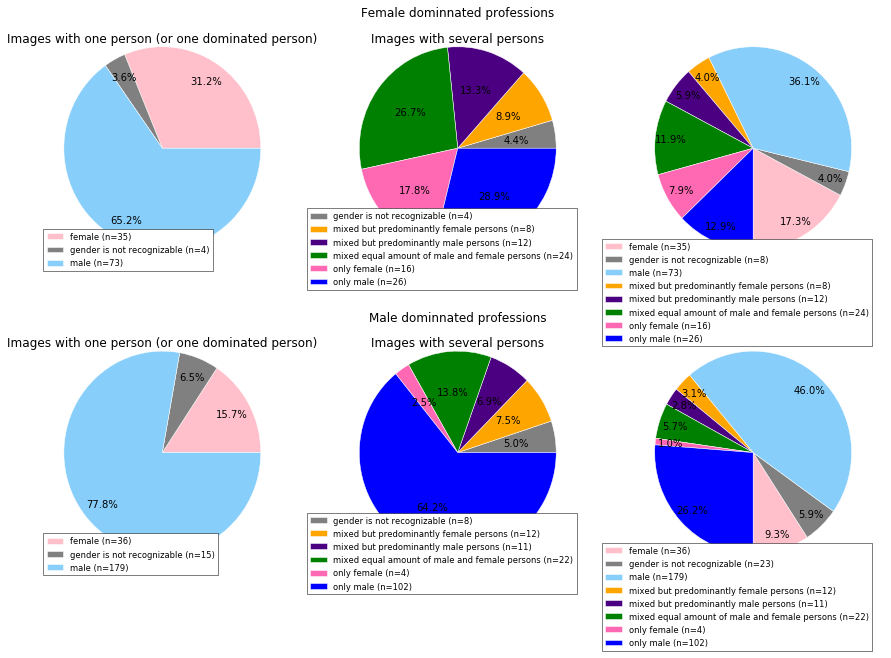

In [21]:
groups=df_images_and_all.groupby("labor_market_domin")
print "Amount of data in each group:",groups.size()
print 
#================hidden subplot
fig, big_axes = plt.subplots( figsize=(15, 10) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(groups.size().index[row-1].title()+" dominnated professions", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    

data={}  
data2={}
i=1    
for group_name, df_group in groups:

    #print "Labour market, where dominant are:",group_name
    #=====singular person
    singular = df_group.groupby("person_singular_dom").size()+df_group.groupby("person_singular_nondom").size()
    #print test
    ax1 = fig.add_subplot(len(groups),3,i) 
    colors = ['pink', 'grey','lightskyblue','green','orange','indigo']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%', pctdistance=0.8)#, labeldistance=1.2
    ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc="best",fontsize='small')
    ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
    

    #=====plural
    plural= df_group.groupby("person_plural").size()
    #print plural
    ax2 = fig.add_subplot(len(groups),3,i+1)
    colors = [ 'grey','orange','indigo','green', 'hotpink', 'blue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%')#,pctdistance=0.46)
    ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.28))#,frameon=False)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    
    #save data
    data[group_name]={"plural":plural.values,"singular":singular.values}
    
    #====all
    ax3 = fig.add_subplot(len(groups),3,i+2)
    s_and_p=singular.add(plural,fill_value=0)
    colors=['pink','grey','lightskyblue','orange','indigo','green', 'hotpink', 'blue' ]
    ax3.pie(s_and_p.values,colors=colors, autopct='%1.1f%%', pctdistance=0.84,startangle=270)
    ax3.legend(s_and_p.index.str.replace("_"," ").values+s_and_p.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.16))#,frameon=False)
    #save data
    data2[group_name]=s_and_p
    i+=3
plt.show()

The null hypothesis states that knowing the level of Variable A does not help you predict the level of Variable B. That is, the variables are independent.

H0: category of image and gender that dominate in profession are independent.

Ha: category of image and gender that dominate in profession are not independent. 

For this analysis, the significance level is 0.05. Using data, we will conduct a chi-square/G- test for independence.

## Simulate the distribution of test statistic

Results from R (Simulating the Chi-squared P-value by using "Monte Carlo" test, Using 100,000 iterations ):

> x <- cbind(A=c(36,23,179,12,11,22,4,102),B=c(35,8,73,8,12,24,16,26))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x

X-squared = 51.057, df = NA, p-value = 1e-05

## G- test (log-likelihood ratio) for independence

In [10]:
#dependent variable: category of image
#independent variable: gender that dominate in profession 
from scipy.stats import chi2_contingency
T_all=[data2["male"].values,data2["female"].values]#[[36,23,179,12,11,22,4,102],[35,8,73,8,12,24,16,26]]
print chi2_contingency(T_all,lambda_="log-likelihood")

(50.279695229433912, 1.2728853066711075e-08, 7, array([[  46.73265651,   20.40439932,  165.8680203 ,   13.1641286 ,
          15.13874788,   30.27749577,   13.1641286 ,   84.25042301],
       [  24.26734349,   10.59560068,   86.1319797 ,    6.8358714 ,
           7.86125212,   15.72250423,    6.8358714 ,   43.74957699]]))


#all cateories of images together=> OLD
#T_all=[np.concatenate([data["male"]["singular"],data["male"]["plural"]]),
       np.concatenate([data["female"]["singular"],data["female"]["plural"]])]
#print chi2_contingency(T_all,lambda_="log-likelihood")[:3]#([[36,15,179,8,12,11,22,4,102],[35,4,73,4,8,12,24,16,26]])

These results indicate that there is a statistically significant relationship between the category of images and gender that dominate in profession 

old:( Pearson’s chi-square with 8 degrees of freedom = 51.55, p = 2.055e-08).
                        
new:( G-value with 7 degrees of freedom = 50.27, p = 1.272e-08).

There is a significant difference in the images composition between the female and male dominated professions, but it would be interesting to see which image categories are a significantly higher proportion of the total in each group of professions. To do that, we will do 2x2 contigency table for each image category vs. all others. 
We will use holm-bonferroni OR Hommel correction in order to controll the familywise error rate.
OR Benjamini-Hochberg the false discovery rate (FDR)

## Post-hoc tests

In [22]:
from statsmodels.sandbox.stats.multicomp import multipletests

p_val=[]
g_val=[]
T_all=[data2["male"].values,data2["female"].values]
#print "g-val, p-val without correction, degrees of freedom, exp_val:"
for i in range(0,len(T_all[0])):
    g,p,df,exp_v=chi2_contingency([[T_all[0][i],T_all[1][i]],[sum(T_all[0])-T_all[0][i],sum(T_all[1])-[T_all[1][i]]]]
                                                       ,lambda_="log-likelihood")
    #print g,p,df 
    g_val.append(g)
    p_val.append(p)
names_c=["female (singular)","gender is not recognizable","male (singular)",#"gender is not recognizable (plural)",
       "mixed but predominantly female persons","mixed but predominantly male persons",
        "mixed, equal amount of male and female","only female (plural)",
      "only male (plural)"]
names_c=data2["male"].index.str.replace("_"," ").str.replace("mixed","mixed,")


#If there are 9 comparisons, applying the Bonferroni correction means that a p-value has to be less than 0.05/9=0.0056 to be significant at the p<0.05 level. Too conservative 
print "Hommel correction:"
res= multipletests(p_val, alpha=0.05, method='hommel')[:2]
print res
#So "female (singular)","only female" and "only male" categories show signifficant difference between the female and male dominated professions.

print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "================ image category =========== p-value_old == reject = p-value_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_val[i],res[0][i],res[1][i])

Hommel correction:
(array([ True, False, False, False, False, False,  True,  True], dtype=bool), array([  4.22807213e-02,   7.51772596e-01,   1.04508000e-01,
         7.51772596e-01,   3.35054567e-01,   6.53174998e-02,
         4.31087812e-04,   1.24496464e-03]))

Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
================ image category =========== p-value_old == reject = p-value_corrected
---------------------------------------------------------------------------
female                                          7.54e-03    True   7.54e-03
gender is not recognizable                      4.07e-01   False   1.74e-01
male                                            2.61e-02    True   1.57e-02
mixed, but predominantly female persons         7.52e-01   False   2.82e-01
mixed, but predominantly male persons           1.12e-01   False   5.58e-02
mixed, equal amount of male and female persons  1.41e-02    True   1.

So "female (singular)" (p=7.54e-03),"male (singular)" (p=1.57e-02),"mixed, equal amount of male and female" (p=1.06e-02),"only female (plural)" (p=1.62e-04) and "only male (plural)" (p=2.67e-04) categories show significant difference between the female and male dominated professions.

Literature:

MacDonald and Gardner (2000):PL MacDonald, RC Gardner. Type I Error Rate Comparisons of Post Hoc Procedures for I j Chi-Square Tables. - Educational and Psychological …, 2000

http://jpktd.blogspot.de/2013/04/multiple-testing-p-value-corrections-in.html

https://en.wikipedia.org/wiki/False_discovery_rate#Classification_of_m_hypothesis_tests

# Group by bias (from page existance on Wiki)

Amount of data in each group: Bias
female       3
male       548
neutral     44
dtype: int64
no_of_persons
several_persons_no_single_persons_depiction_is_dominant    3
dtype: int64
no_of_persons
one_person                                                 270
several_persons_but_one_persons_depiction_is_dominant       50
several_persons_no_single_persons_depiction_is_dominant    228
dtype: int64
no_of_persons
one_person                                                 22
several_persons_but_one_persons_depiction_is_dominant       3
several_persons_no_single_persons_depiction_is_dominant    19
dtype: int64


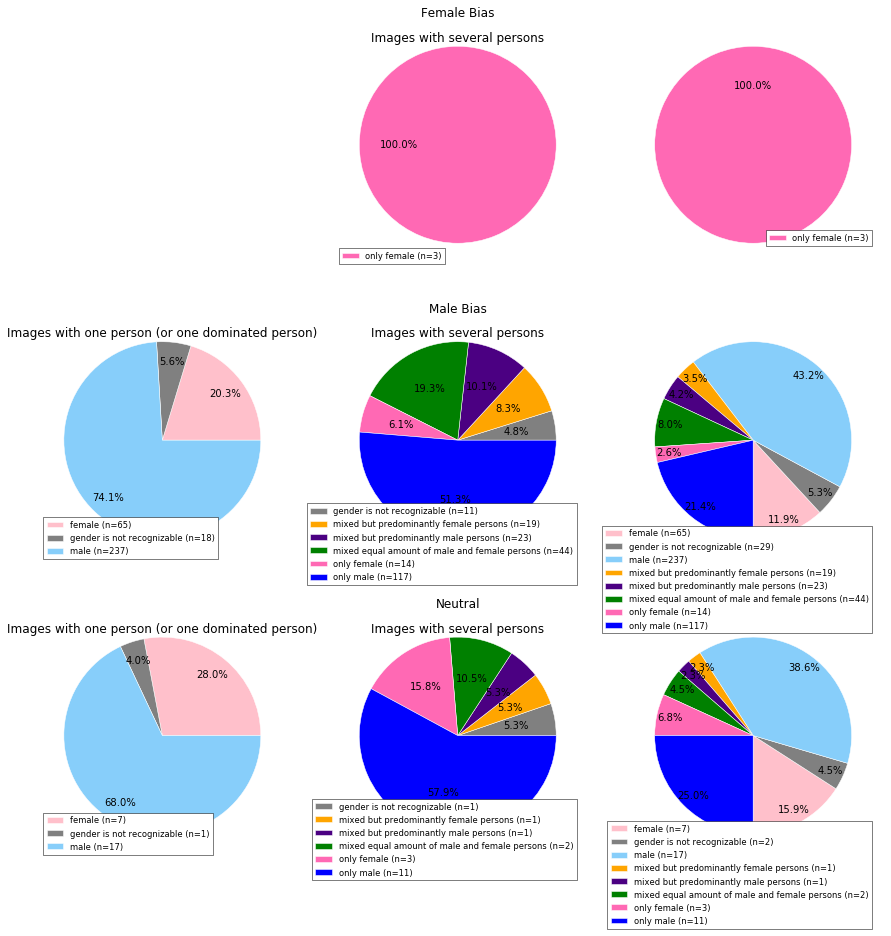

In [23]:
groups=df_images_and_all.groupby("Bias")
print "Amount of data in each group:",groups.size()

#================hidden subplot
fig, big_axes = plt.subplots( figsize=(15, 5*len(groups)) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(groups.size().index[row-1].title() if groups.size().index[row-1]=="neutral" else groups.size().index[row-1].title()+" Bias", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
  
data={}
i=1    
for group_name, df_group in groups:
    num_of_pers =  df_group.groupby("no_of_persons").size()
    print num_of_pers
    #print "Bias:",group_name
    #=====singular person
    if (df_group.person_singular_dom.count()>0) | (df_group.person_singular_nondom.count()>0):#
        #singular = df_group.groupby("person_singular_dom").size()+df_group.groupby("person_singular_nondom").size()
        singular=df_group.groupby("person_singular_dom").size().add(df_group.groupby("person_singular_nondom").size(),fill_value=0)
        #print test
        ax1 = fig.add_subplot(3,3,i) 
        colors = ['pink', 'grey','lightskyblue']
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%', pctdistance=0.8)#, labeldistance=1.2)
        ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc="best",fontsize='small')
        ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
        singular_values=singular.values
    else:
        singular=pd.Series()
        ax1 = fig.add_subplot(3,3,i) 
        ax1.pie([0])
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1._frameon = False
        singular_values=np.array([0,0,0])
    #=====plural
    plural= df_group.groupby("person_plural").size()
    plural_values=plural.values
    #print plural
    ax2 = fig.add_subplot(3,3,i+1)
    if len(plural)==1:
        colors = ['hotpink']
        plural_values=np.array([plural.values[0],0,0,0,0,0])
    else:
        colors = [ 'grey','orange','indigo','green', 'hotpink', 'blue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%')#,pctdistance=0.46)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    if len(plural)>4:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.26))#,frameon=False)
    else:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
    data[group_name]={"plural":plural_values,"singular":singular_values}
    
    #=====all together
    ax3 = fig.add_subplot(3,3,i+2)
    s_and_p=singular.add(plural,fill_value=0)
    if len(s_and_p)==1:
        colors=['hotpink']
        #save data
        data2[group_name]=[0,0,0,0,0,0,s_and_p.values[0],0]
        p_dt=0.6
    else:    
        colors=['pink','grey','lightskyblue','orange','indigo','green','hotpink','blue']
        #save data
        data2[group_name]=s_and_p
        p_dt=0.86
    ax3.pie(s_and_p.values,colors=colors, autopct='%1.1f%%', pctdistance=p_dt,startangle=270)
    ax3.legend(s_and_p.index.str.replace("_"," ").values+s_and_p.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.17))#,frameon=False)
    
    i+=3
plt.show()

The null hypothesis states that knowing the level of Variable A does not help you predict the level of Variable B. That is, the variables are independent.

H0: category of image and assigned bias category are independent.

Ha: category of image and assigned bias category are not independent. 

In [16]:
T_all=[data2["male"].values,data2["neutral"].values,data2["female"]]
print T_all
print chi2_contingency(T_all,lambda_="log-likelihood")[:3]

[array([  65.,   29.,  237.,   19.,   23.,   44.,   14.,  117.]), array([  7.,   2.,  17.,   1.,   1.,   2.,   3.,  11.]), [0, 0, 0, 0, 0, 0, 3.0, 0]]
(25.097775060433758, 0.033614313152606129, 14)


#===OLD
#We can see that in female bias group all the images  are "only female". 
#We will exclude female bias group from the following G-test for independence
#H0: category of image and assigned bias category (male and neutral) are independent.
#Ha: category of image and assigned bias category (male and neutral) are not independent. 
#print chi2_contingency([[65,18,237,11,19,23,44,14,117],[7,1,17,1,1,1,2,3,11]],lambda_="log-likelihood")[:3]
#(4.3936937072585724, 0.81997209625336565, 8L)
#Since the p-value (0.82) is more than the significance level (0.05), we can accept the null hypothesis. Thus, we concludethat there is no relationship between the category of image and assigned bias category (male or neutral).

While we have cells with values<5 we will perform Monte Carlo simulations ( other option would be Fisher's exact test)

## Simulate the distribution of test statistic

Results from R (Simulating the Chi-squared P-value by using "Monte Carlo" test, Using 100,000 iterations ):  

    For all groups:
> x <- cbind(A=c(65,29,237,19,23,44,14,117),B=c(0,0,0,0,0,0,3,0),C=c(7,2,17,1,1,2,3,11))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)
data:  x
X-squared = 91.126, df = NA, p-value = 6e-05

    For male bias and neutral bias comparison:
> x <- cbind(A=c(65,29,237,19,23,44,14,117),B=c(7,2,17,1,1,2,3,11))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)
data:  x
X-squared = 4.8032, df = NA, p-value = 0.6901

    For male bias and female bias comparison: 
> x <- cbind(A=c(65,29,237,19,23,44,14,117),B=c(0,0,0,0,0,0,3,0))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)
data:  x
X-squared = 94.751, df = NA, p-value = 6e-05

    For neutral and female bias comparison:
> x <- cbind(A=c(7,2,17,1,1,2,3,11),B=c(0,0,0,0,0,0,3,0))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)
data:  x
X-squared = 21.898, df = NA, p-value = 0.03449


According to the results category of image and assigned bias category are not independent. Thus, a signifficant difference exists in a distribution of image categories among bias categories. We will perform multiple chi square tests over all pairs of bias categories in order to access which bias categories has signifficant difference.

In [125]:
p_all=[ 0.6901,  6e-05, 0.03449]
names_c=["male bias and neutral bias","male bias and female bias","neutral and female bias"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "========================== reject null-hyp.== p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9}   {:>7.2e}".format(names_c[i],res[0][i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
========================== reject null-hyp.= p_val_corrected
---------------------------------------------------------------------------
male bias and neutral bias     False       4.60e-01
male bias and female bias      True        1.20e-04
neutral and female bias        True        3.45e-02


The results of multiple chi-square tests with two stage FDR correction of Benjamini-Hochberg show that significant difference observed between pairs: male bias and female bias (p=1.20e-04); neutral and female bias (p=3.45e-02). There is no signifficant differnce (p=0.46) in distribution of image categories between male bias and neutral categories.

We can test also among each group pair what image categories show the signifficant difference.

In [38]:
#Check neutral and female
p_val=[]
for i in range(0,len(T_all[0])):
    g,p,df,exp_v=chi2_contingency([[T_all[1][i],T_all[2][i]],[sum(T_all[1])-T_all[1][i],sum(T_all[2])-[T_all[2][i]]]]
                                                       ,lambda_="log-likelihood")
    p_val.append(p)
names_c=data2["male"].index.str.replace("_"," ").str.replace("mixed","mixed,")
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "FEMALE BIAS AND NEUTRAL === image category | p-value_old | reject | p-value_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_val[i],res[0][i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
FEMALE BIAS AND NEUTRAL === image category | p-value_old | reject | p-value_corrected
---------------------------------------------------------------------------
female                                          9.30e-01   False   8.14e-01
gender is not recognizable                      3.85e-01   False   5.15e-01
male                                            4.42e-01   False   5.15e-01
mixed, but predominantly female persons         2.20e-01   False   5.14e-01
mixed, but predominantly male persons           2.20e-01   False   5.14e-01
mixed, equal amount of male and female persons  3.85e-01   False   5.15e-01
only female                                     3.07e-03    True   2.15e-02
only male                                       7.68e-01   False   7.68e-01


The results show a significant difference (p=0.0215) in image category "only female" between female bias and neutral groups.

In [42]:
#Check male and female bias groups
p_val=[]
for i in range(0,len(T_all[0])):
    g,p,df,exp_v=chi2_contingency([[T_all[0][i],T_all[2][i]],[sum(T_all[0])-T_all[0][i],sum(T_all[2])-[T_all[2][i]]]]
                                                       ,lambda_="log-likelihood")
    p_val.append(p)
names_c=data2["male"].index.str.replace("_"," ").str.replace("mixed","mixed,")
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "MALE AND FEMALE BIAS ====== image category | p-value_old | reject | p-value_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_val[i],res[0][i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
MALE AND FEMALE BIAS ====== image category | p-value_old | reject | p-value_corrected
---------------------------------------------------------------------------
female                                          8.03e-01   False   7.37e-01
gender is not recognizable                      4.73e-01   False   6.62e-01
male                                            3.28e-01   False   6.62e-01
mixed, but predominantly female persons         3.57e-01   False   6.62e-01
mixed, but predominantly male persons           4.05e-01   False   6.62e-01
mixed, equal amount of male and female persons  6.23e-01   False   7.27e-01
only female                                     1.02e-04    True   7.17e-04
only male                                       8.42e-01   False   7.37e-01


The results show a significant difference (p=7.17e-04) in image category "only female" between male and female bias groups.

# Group by gender of profession label

Amount of data in each group: prof_gender
female      12
male       558
neutral     25
dtype: int64
no_of_persons
one_person                                                 5
several_persons_no_single_persons_depiction_is_dominant    7
dtype: int64
no_of_persons
one_person                                                 278
several_persons_but_one_persons_depiction_is_dominant       51
several_persons_no_single_persons_depiction_is_dominant    229
dtype: int64
no_of_persons
one_person                                                  9
several_persons_but_one_persons_depiction_is_dominant       2
several_persons_no_single_persons_depiction_is_dominant    14
dtype: int64


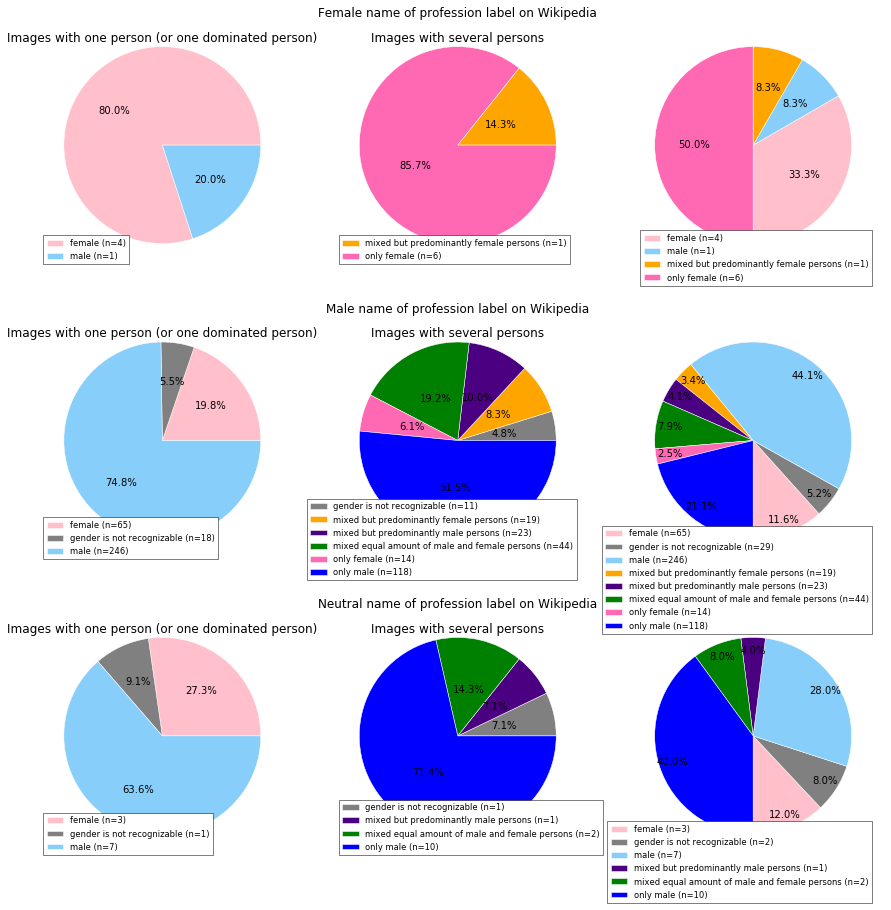

In [43]:
groups=df_images_and_all.groupby("prof_gender")
print "Amount of data in each group:",groups.size()

#================hidden subplot
fig, big_axes = plt.subplots( figsize=(15, 5*len(groups)) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(""+groups.size().index[row-1].title()+" name of profession label on Wikipedia", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
    
i=1    
for group_name, df_group in groups:
    num_of_pers =  df_group.groupby("no_of_persons").size()
    print num_of_pers

    #=====singular person
    if (df_group.person_singular_dom.count()>0) | (df_group.person_singular_nondom.count()>0):#
        if (df_group.person_singular_dom.count()>0) & (df_group.person_singular_nondom.count()>0):
            singular=df_group.groupby("person_singular_dom").size().add(df_group.groupby("person_singular_nondom").size(),fill_value=0)
        elif (df_group.person_singular_dom.count()>0):
            singular=df_group.groupby("person_singular_dom").size()
        else:
            singular=df_group.groupby("person_singular_nondom").size()
        #print singular
        ax1 = fig.add_subplot(3,3,i) 
        if len(singular)==2:
            colors = ['pink', 'lightskyblue']
            singular_values=np.array([singular.values[0],0,singular.values[1]])
        else:
            colors = ['pink', 'grey','lightskyblue']
            singular_values=np.array(singular.values, dtype=int64)
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
        ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
        ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
    else:
        ax1 = fig.add_subplot(3,3,i) 
        ax1.pie([0])
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1._frameon = False
    #=====plural
    plural= df_group.groupby("person_plural").size()
    #print plural
    ax2 = fig.add_subplot(3,3,i+1)
    if len(plural)==1:
        colors = ['hotpink']
    elif len(plural)==2:
        colors = ['orange', 'hotpink']
        plural_values=np.array([0,plural.values[0],0,0,plural.values[1],0])
    elif len(plural)==4:
        colors = ['grey','indigo','green', 'blue']
        plural_values=np.array([plural.values[0],0,plural.values[1],plural.values[2],0,plural.values[3]],dtype=int64)
    else:
        colors = [ 'grey','orange','indigo','green', 'hotpink', 'blue' ]
        plural_values=plural.values
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%',pctdistance=0.48)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    if len(plural)<5:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
    else:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.28))#,frameon=False)
    data[group_name]={"plural":plural_values,"singular":singular_values} 
    
    #=====all together
    ax3 = fig.add_subplot(3,3,i+2)
    s_and_p=singular.add(plural,fill_value=0)
    if len(s_and_p)==4:
        colors=['pink','lightskyblue','orange','hotpink']
        #save data
        data2[group_name]=[s_and_p.values[0],0,s_and_p.values[1],s_and_p.values[2],0,0,s_and_p.values[3],0]
        p_dt=0.6
    elif len(s_and_p)==6:   
        colors=['pink','grey','lightskyblue','indigo','green','blue']
        #save data
        data2[group_name]=[s_and_p.values[0],s_and_p.values[1],s_and_p.values[2],
                           0,s_and_p.values[3],s_and_p.values[4],0,s_and_p.values[5]]
        p_dt=0.86
    else:    
        colors=['pink','grey','lightskyblue','orange','indigo','green','hotpink','blue']
        #save data
        data2[group_name]=s_and_p
        p_dt=0.86
    ax3.pie(s_and_p.values,colors=colors, autopct='%1.1f%%', pctdistance=p_dt,startangle=270)
    ax3.legend(s_and_p.index.str.replace("_"," ").values+s_and_p.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.17))#,frameon=False)
    
    i+=3
plt.show()

The null hypothesis states that knowing the level of Variable A does not help you predict the level of Variable B. That is, the variables are independent.

H0: category of image and gender of profession label are independent.

Ha: category of image and gender of profession label are not independent. 

In [44]:
T_all=data2["female"],data2["male"].values,data2["neutral"]
print T_all

([4.0, 0, 1.0, 1.0, 0, 0, 6.0, 0], array([  65.,   29.,  246.,   19.,   23.,   44.,   14.,  118.]), [3.0, 2.0, 7.0, 0, 1.0, 2.0, 0, 10.0])


## Simulate the distribution of test statistic

Results from R (Simulating the Chi-squared P-value by using "Monte Carlo" test, Using 100,000 iterations ):  

> x <- cbind(A=c(4,0,1,1,0,0,6,0),B=c(65,29,246,19,23,44,14,118),C=c(3,2,7,0,1,2,0,10))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)
data:  x
X-squared = 99.857, df = NA, p-value = 1e-05

According to the results category of image and gender of profession name are not independent. Thus, a signifficant difference (p=1e-05) exists in a distribution of image categories among different genders of profession name. 


> x <- cbind(A=c(4,0,1,1,0,0,6,0),B=c(65,29,246,19,23,44,14,118))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 88.955, df = NA, p-value = 1e-05

> x <- cbind(A=c(4,0,1,1,0,0,6,0),B=c(3,2,7,0,1,2,0,10))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 25.184, df = NA, p-value = 1e-05

> x <- cbind(A=c(65,29,246,19,23,44,14,118),B=c(3,2,7,0,1,2,0,10))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 7.1363, df = NA, p-value = 0.3901

We will perform multiple chi square tests over all image categories in order to access which image category has signifficant difference.

## Post hoc tests

In [48]:
from scipy.stats import chi2_contingency
p_val=[]
g_val=[]
print "g-val, p-val without correction, degrees of freedom, exp_val:"
for i in range(0,len(T_all[0])):
    g,p,df,exp_v=chi2_contingency([[T_all[0][i],T_all[1][i],T_all[2][i]],
                                   [sum(T_all[0])-T_all[0][i],sum(T_all[1])-T_all[1][i],sum(T_all[2])-T_all[2][i]]]
                                                        ,lambda_="log-likelihood")
    #print g,p,df
    g_val.append(g)
    p_val.append(p)
names_c=["female (singular)","gender is not recognizable","male (singular)",
       "mixed, but predominantly female persons",
       "mixed, but predominantly male persons","mixed, equal amount of male and female","only female (plural)",
      "only male (plural)"]
#names_c=data2["male"].keys()

print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "FEMALE,MALE AND NEUTRAL === image category | p-value_old | reject | p-value_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_val[i],res[0][i],res[1][i])

g-val, p-val without correction, degrees of freedom, exp_val:

Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
FEMALE,MALE AND NEUTRAL === image category | p-value_old | reject | p-value_corrected
---------------------------------------------------------------------------
female (singular)                               1.50e-01   False   1.88e-01
gender is not recognizable                      4.44e-01   False   3.17e-01
male (singular)                                 7.38e-03    True   1.23e-02
mixed, but predominantly female persons         3.06e-01   False   3.06e-01
mixed, but predominantly male persons           6.07e-01   False   3.79e-01
mixed, equal amount of male and female          3.77e-01   False   3.14e-01
only female (plural)                            1.03e-06    True   5.17e-06
only male (plural)                              6.08e-03    True   1.23e-02


So "male (singular)" (p=1.23e-02),"only female (plural)" (p=5.17e-06)and "only male (plural)" (p=1.23e-02) categories show significant difference between the male,female and neutral professions.

> x <-cbind(A=c(4, 65, 3), B=c(8, 493, 22))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 5.1935, df = NA, p-value = 0.08503

> x <-cbind(A=c(0, 29, 2), B=c(12, 529, 23))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 1.0538, df = NA, p-value = 0.5921

> x <-cbind(A=c(1, 246,7), B=c(11, 312, 18))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 8.4392, df = NA, p-value = 0.01339

> x <-cbind(A=c(1, 19, 0), B=c(11, 539, 25))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 1.7861, df = NA, p-value = 0.3726

> x <-cbind(A=c(0, 23, 1), B=c(12, 535, 24))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 0.51568, df = NA, p-value = 1

> x <-cbind(A=c(0, 44, 2), B=c(12, 514, 23))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 1.0266, df = NA, p-value = 0.7092

> x <-cbind(A=c(6, 14, 0), B=c(6, 544, 25))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 82.472, df = NA, p-value = 1e-05

> x <-cbind(A=c(0, 118, 10), B=c(12, 440, 15))

> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 8.3938, df = NA, p-value = 0.01549

In [51]:
p_all=[0.08503,0.5921,0.01339,0.3726,1,0.7092,1e-05,0.01549]
print "Two stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "FEMALE,MALE AND NEUTRAL === image category | p-value_old | reject | p-value_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_all[i],res[0][i],res[1][i])

Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
FEMALE,MALE AND NEUTRAL === image category | p-value_old | reject | p-value_corrected
---------------------------------------------------------------------------
female (singular)                               8.50e-02   False   1.06e-01
gender is not recognizable                      5.92e-01   False   4.93e-01
male (singular)                                 1.34e-02    True   2.58e-02
mixed, but predominantly female persons         3.73e-01   False   3.73e-01
mixed, but predominantly male persons           1.00e+00   False   6.25e-01
mixed, equal amount of male and female          7.09e-01   False   5.07e-01
only female (plural)                            1.00e-05    True   5.00e-05
only male (plural)                              1.55e-02    True   2.58e-02


So "male (singular)" (p=2.58e-02),"only female (plural)" (p=5.00e-05)and "only male (plural)" (p=2.58e-02) categories show significant difference between the male,female and neutral professions.

# More:

http://www.ats.ucla.edu/stat/stata/whatstat/whatstat.htm

http://www.ats.ucla.edu/stat/mult_pkg/whatstat/choosestat.html

Image type
female                                             72
gender is not recognizable                         31
male                                              254
mixed, but predominantly female persons            20
mixed, but predominantly male persons              24
mixed, equal amount of male and female persons     46
only female                                        20
only male                                         128
dtype: int64


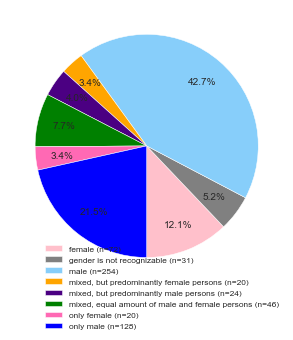

In [8]:
df_images_and_all_onlyfm=df_images_and_all[~(df_images_and_all.no_of_persons.str.contains("no_person|image_is_not_shown"))]
df_images_and_all_onlyfm['Image type']=df_images_and_all_onlyfm.person_plural.str.cat([df_images_and_all_onlyfm.person_singular_dom,
                                        df_images_and_all_onlyfm.person_singular_nondom],na_rep="").str.replace("_"," ")
df_images_and_all_onlyfm['Image type']=df_images_and_all_onlyfm['Image type'].str.replace("mixed","mixed,")
all_people=df_images_and_all_onlyfm.groupby('Image type').size()
print all_people
colors=['pink','grey','lightskyblue','orange','indigo','green','hotpink','blue']
plt.figure(1, figsize=(5,5))
plt.pie(all_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.76,startangle=270)
plt.legend(all_people.index.values+all_people.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.17))
plt.show()

There are 53.6% man and 46.4% woman according to German labour Market statistics.


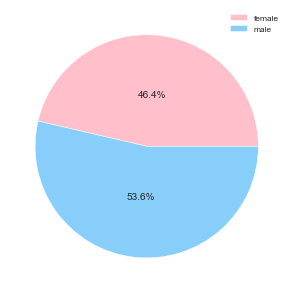

Statistics about professions that are described on Wikipedia: 62.1% man and 37.9% woman in German Labour market.


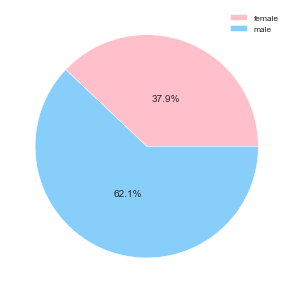

Images results: We combined singular persons and several persons according to magority (male or female):
female    112
male      406
dtype: float64


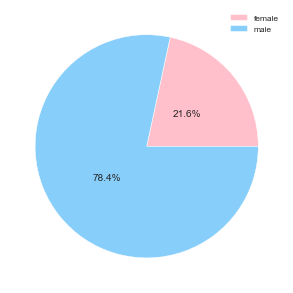

In [9]:
import pandas as pd
#From German labour Market Statistics (2015):
m_n=16504172#Männer 
f_n=14267125#Frauen 
m_proc=100*float(m_n)/(m_n+f_n)
f_proc=100-m_proc
print "There are {0:.1f}% man and {1:.1f}% woman according to German labour Market statistics.".format(m_proc,f_proc)
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie([f_n,m_n], colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(["female", "male"],loc="best",fontsize='small')
plt.show()
#===data where if there are male and female profession then statistics count it 2 times:
#all_df=pd.read_csv("de/labour_market_for_all_pages.csv",sep='\t', encoding='utf-8',index_col=0)
#f_wiki_proc=all_df.Frauen.mean()
#m_wiki_proc=100-f_wiki_proc
#print "There are {0:.1f}% man and {1:.1f}% woman according to German labour Market statistics.".format(m_wiki_proc,f_wiki_proc)
#===
df_all_subgroups=pd.read_csv("de/labourmarket_subgroups.csv",sep='\t', encoding='utf-8',index_col=0)
f_wiki_proc=df_all_subgroups.Frauen_ratio.mean()
m_wiki_proc=100-f_wiki_proc
print "Statistics about professions that are described on Wikipedia: {0:.1f}% man and {1:.1f}% woman in German Labour market.".format(m_wiki_proc,f_wiki_proc)
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie([f_wiki_proc,m_wiki_proc], colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(["female", "male"],loc="best",fontsize='small')
plt.show()



person_all=df_images_and_all_onlyfm[~(df_images_and_all_onlyfm.no_of_persons.str.contains("no_person|image_is_not_shown"))]
person_all.loc[:,'person_plural']=person_all['person_plural'].str.replace("only_","")\
    .str.replace("mixed_but_predominantly_","").str.replace("_persons","")
all_singular_persons = person_all.groupby("person_singular_dom").size()+person_all.groupby("person_singular_nondom").size()
several_people=person_all.groupby("person_plural").size()
new_all=several_people.add(all_singular_persons ,fill_value=0).drop(["gender_is_not_recognizable",
                                                                     "mixed_equal_amount_of_male_and_female"])

print "Images results: We combined singular persons and several persons according to magority (male or female):\n",new_all
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie(new_all.values, colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(new_all.index,loc="best",fontsize='small')
plt.show()
#print person_all[pd.notnull(person_all['person_plural'])].person_plural.value_counts(normalize=True,dropna=False)
f_perc_all=100. * new_all.female / (new_all.female+new_all.male)
m_perc_all=100. * new_all.male / (new_all.female+new_all.male)

In [10]:
#singular["gender is not recognizable\nor equal amount of male and female"]= singular['gender is not recognizable']\
#+ singular['mixed, equal amount of male and female']
#singular.drop(["gender is not recognizable","mixed, equal amount of male and female"],inplace=True)

In [11]:
from scipy.stats import chisquare,ks_2samp,chi2_contingency

from scipy.stats import chisquare
print chisquare([112,406])#goodnes of fit where the expected frequencies are uniform 
print chisquare([20593.8969521045, 23784.433962264149])#goodnes of fit where we expect 0.5 chance for both

#check whether amount of male and female in German labour market and amount of male afemale persons on images 
#are from the same distribution
cat1=[df_all_subgroups.Frauen.mean(),df_all_subgroups[u'Männer'].mean()]
print cat1
cat2=new_all.values
print cat2
print chi2_contingency(np.array([cat1, cat2]))

m_n=16504172#Männer 
f_n=14267125#Frauen 
cat3=[f_n,m_n]
print chi2_contingency(np.array([cat3, cat2]))

#does our sample of professions build from the German labour market?
print chi2_contingency(np.array([cat3, cat1]))

#print ks_2samp(cat1, cat2)#samples are drawn from the same distribution?
#print chisquare(np.array([cat1,cat2]))#goodnes of fit

Power_divergenceResult(statistic=166.86486486486487, pvalue=3.5805340629162723e-38)
Power_divergenceResult(statistic=229.38056036493666, pvalue=8.1364098032284914e-52)
[20593.8969521045, 23784.433962264149]
[ 112.  406.]
(125.56719737871414, 3.8241871102153773e-29, 1L, array([[ 20466.99870802,  23911.33220635],
       [   238.89824408,    279.10175592]]))
(126.5344502095431, 2.3488863619951363e-29, 1L, array([[  1.42669968e+07,   1.65043002e+07],
       [  2.40168764e+02,   2.77831236e+02]]))
(0.027281685789242539, 0.86880885060363078, 1L, array([[ 14267142.839137  ,  16504154.160863  ],
       [    20576.05781511,     23802.27309926]]))


16.5 and 14.2 Mio of women and men involved in German labour market.
They are not uniformaly distibuted (p=3.58e-38), there are 53.6% of men and almost 46.4% of women.

2059.86 and 23784.433 -means of women and men involved in German labour market (professions from our sample, i.e., those which have page on Wiki).
They are not uniformaly distibuted (p=8.13e-52), there are 62% of men and almost 38% of women.

We also check whether total amount of women and men involved in German Labour market and sample of professions that has Wikipedia artocles are drawn from the same distribution. 
Result shows that they follow same distribution (p=0.8688).


We check whether amount of female and male images are drown from the same distribution as amount of women and men involved in German Labour market.
Results reveal that amount of female and male images and amount of women and men involved in German labour market are not drawn from the same distribution (p=3.82e-29). Wikipedia articles of professions has much more male images (78.4%) than female images.  


Image type simple
female                                    112
gender is not recognizable                 31
male                                      406
mixed, equal amount of male and female     46
dtype: int64


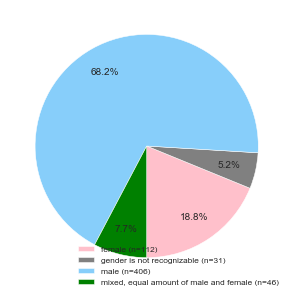

Image type simple
female                                                            112
male                                                              406
gender is not recognizable\nor equal amount of male and female     77
dtype: int64


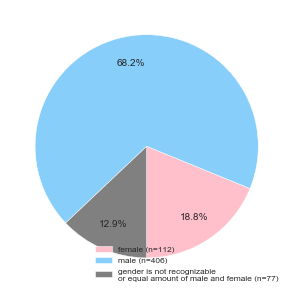

In [12]:
df_images_and_all_onlyfm['Image type simple']=df_images_and_all_onlyfm['Image type'].str.replace("only ","")\
    .str.replace("mixed, but predominantly ","").str.replace(" persons","")
all_people=df_images_and_all_onlyfm.groupby('Image type simple').size()
print all_people
colors=['pink','grey','lightskyblue','green']
plt.figure(1, figsize=(5,5))
plt.pie(all_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.76,startangle=270)
plt.legend(all_people.index.values+all_people.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.17))
plt.show()



all_people["gender is not recognizable\nor equal amount of male and female"]= all_people['gender is not recognizable'] \
+ all_people['mixed, equal amount of male and female']
all_people.drop(["gender is not recognizable",'mixed, equal amount of male and female'],inplace=True)
print all_people
colors=['pink','lightskyblue','grey']
plt.figure(1, figsize=(5,5))
plt.pie(all_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.76,startangle=270)
plt.legend(all_people.index.values+all_people.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.17))
plt.show()



Image type simple
female    112
male      406
dtype: int64


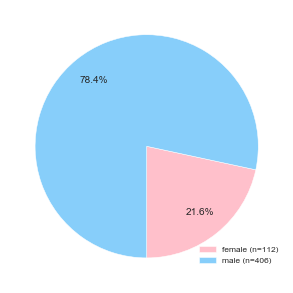

In [13]:
all_people=df_images_and_all_onlyfm.groupby('Image type simple').size().drop(["gender is not recognizable",
                                                                   "mixed, equal amount of male and female"])
print all_people
colors=['pink','lightskyblue']
plt.figure(1, figsize=(5,5))
plt.pie(all_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.76,startangle=270)
plt.legend(all_people.index.values+all_people.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
plt.show()

In [14]:
from collections import Counter
print "Number of articles",len(df_images_and_all_onlyfm.profession.unique())
print Counter(list(df_images_and_all_onlyfm.profession)).most_common(50)
print "Number of articles for wich we have labour market data",\
    len(df_images_and_all_onlyfm[~df_images_and_all_onlyfm.labor_market_domin.isnull()].profession.unique())
print "Number of articles for wich we assigned Bias",\
    len(df_images_and_all_onlyfm[~df_images_and_all_onlyfm.Bias.isnull()].profession.unique())   
print "Number of articles for wich we have gender of prof.",\
    len(df_images_and_all_onlyfm[~df_images_and_all_onlyfm.prof_gender.isnull()].profession.unique())
print "Number of articles for wich we have male or female image",\
    len(df_images_and_all_onlyfm[df_images_and_all_onlyfm["Image type simple"].isin(["male","female"])].profession.unique()) 

Number of articles 283
[(u'T\xe4towierer', 9), (u'Landwirt', 8), (u'Schmied', 8), (u'Zusteller', 7), (u'Clown', 7), (u'Schneider', 7), (u'Taxi', 7), (u'Hafenarbeiter', 7), (u'Journalist', 7), (u'Dachdecker', 6), (u'Drechsler', 6), (u'Zauberer', 6), (u'Flugbegleiter', 6), (u'Rechtsanwalt', 6), (u'Schornsteinfeger', 6), (u'Pantomime', 6), (u'Schwei\xdfer', 5), (u'Architekt', 5), (u'Telefonist', 5), (u'Fotograf', 5), (u'Maschinenbauingenieur', 5), (u'Kameramann', 5), (u'Friseur', 5), (u'Buchbinder', 5), (u'Gleisbauer', 5), (u'K\xfcrschner', 5), (u'Diakon', 5), (u'J\xe4ger', 4), (u'Pfarrer', 4), (u'Rettungsschwimmer', 4), (u'Steinhauer', 4), (u'Butler', 4), (u'Vergolder', 4), (u'Pflasterer', 4), (u'Zahnarzt', 4), (u'Steinmetz', 4), (u'Lehrer', 4), (u'Imker', 4), (u'Physiker', 4), (u'Model', 4), (u'Kapit\xe4n', 3), (u'Goldschl\xe4ger', 3), (u'Technischer Zeichner', 3), (u'Zimmerer', 3), (u'Geb\xe4udereiniger', 3), (u'Glasmacher', 3), (u'Hostess', 3), (u'Fremdenf\xfchrer', 3), (u'Saaldiener'

In [14]:
#df_images_and_all_onlyfm[df_images_and_all_onlyfm.profession==u'Lehrer']

Image type simple
female                                    112
gender is not recognizable                 31
male                                      406
mixed, equal amount of male and female     46
no person                                 311
dtype: int64
906


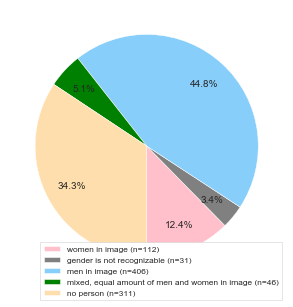

In [15]:
all_images_and_fm=df_images_and_all_onlyfm.groupby('Image type simple').size()
all_images_and_fm["no person"]=result_all_grouped["no_person"]#+result_all_grouped["image_is_not_shown"] 
print all_images_and_fm
print np.sum(all_images_and_fm.values)

colors=['pink',"grey",'lightskyblue',"green",'navajowhite']
plt.figure(1, figsize=(5,5))
plt.pie(all_images_and_fm.values, colors=colors, autopct='%1.1f%%',pctdistance=0.76,startangle=270)
new_names=[s.replace('male and female' , 'men and women in image').replace('female' ,
                'women in image').replace('male' , 'men in image') for s in all_images_and_fm.index.values]
new_names=new_names+all_images_and_fm.apply(lambda x:" (n="+str(int(x))+")").values
plt.legend(new_names,fontsize='small',bbox_to_anchor=(1, 0.17),frameon=True)
plt.savefig("de/images_all.png",dpi=500)
plt.show()

In [16]:
from scipy.stats import chisquare
print chisquare([112,31,406,46,311])#goodnes of fit where the expected frequencies are uniform 
print""
print chisquare([31,(906-31.)/4],[181.2,181.2 ])#181,2
print chisquare([406,(906-406.)/4],[181.2,181.2 ])#181,2
print chisquare([46,(906-46.)/4],[181.2,181.2 ])#181,2
print chisquare([311,(906-311.)/4],[181.2,181.2 ])#181,2
print chisquare([31,(906-31.)/4])
print chisquare([406,(906-406.)/4])
print chisquare([46,(906-46.)/4])
print chisquare([311,(906-311.)/4])

Power_divergenceResult(statistic=623.67991169977927, pvalue=1.1613153149253013e-133)

Power_divergenceResult(statistic=132.28500275938191, pvalue=1.2960991149778852e-30)
Power_divergenceResult(statistic=296.32163355408397, pvalue=2.0853538918732521e-66)
Power_divergenceResult(statistic=107.18256070640176, pvalue=4.0599358858933417e-25)
Power_divergenceResult(statistic=98.791625275938216, pvalue=2.8051825710543598e-23)
Power_divergenceResult(statistic=141.14139139139138, pvalue=1.4983898085005851e-32)
Power_divergenceResult(statistic=148.7024482109228, pvalue=3.3310537121062208e-34)
Power_divergenceResult(statistic=109.42911877394636, pvalue=1.306954560304374e-25)
Power_divergenceResult(statistic=57.259516041326805, pvalue=3.8193664881781427e-14)


In [17]:
person_docs_andnopers = result_all[~(result_all.no_of_persons.str.contains("image_is_not_shown"))] #891 images (unique)
#merge image with url of article
result_and_pages_andnopers = pd.merge(df, person_docs_andnopers, how="right", on="real_url")
#merga all data and image results
df_images_and_all_andnopers = pd.merge(about_pages,result_and_pages_andnopers, how="right", on="profession")#910 images

df_images_and_all_andnopers['Image type']=df_images_and_all_andnopers.person_plural.str.cat([df_images_and_all_andnopers.person_singular_dom,
                                        df_images_and_all_andnopers.person_singular_nondom],na_rep="").str.replace("_"," ")
df_images_and_all_andnopers['Image type']=df_images_and_all_andnopers['Image type'].str.replace("mixed","mixed,")
df_images_and_all_andnopers['Image type']=df_images_and_all_andnopers['Image type'].apply(lambda x: "no person" if x=="" else x)
df_images_and_all_andnopers['Image type simple']=df_images_and_all_andnopers['Image type'].str.replace("only ","")\
    .str.replace("mixed, but predominantly ","").str.replace(" persons","")

print "Number of articles",len(df_images_and_all_andnopers.profession.unique())
#print Counter(list(df_images_and_all_onlyfm.profession)).most_common(50)
print "Number of articles for wich we have labour market data",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.labor_market_domin.isnull()].profession.unique())
print "Number of articles for wich we assigned Bias",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.Bias.isnull()].profession.unique())   
print "Number of articles for wich we have gender of prof.",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.prof_gender.isnull()].profession.unique())
print "Number of articles for wich we have labour market data [diff >40, at least 70 to 30]",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.labor_market70_30.isnull()].profession.unique())
print "Number of articles for wich we have labour market data [diff >60, at least 80 to 20]",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.labor_market80_20.isnull()].profession.unique())
print "Number of articles for wich we have labour market data [diff >80, at least 90 to 10]",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.labor_market90_10.isnull()].profession.unique())
print "Number of articles for wich we have labour market data [diff >90, at least 95 to 5]",\
    len(df_images_and_all_andnopers[~df_images_and_all_andnopers.labor_market95_5.isnull()].profession.unique())

Number of articles 345
Number of articles for wich we have labour market data 341
Number of articles for wich we assigned Bias 345
Number of articles for wich we have gender of prof. 345
Number of articles for wich we have labour market data [diff >40, at least 70 to 30] 210
Number of articles for wich we have labour market data [diff >60, at least 80 to 20] 163
Number of articles for wich we have labour market data [diff >80, at least 90 to 10] 110
Number of articles for wich we have labour market data [diff >90, at least 95 to 5] 68


## Group according dominated gender in profession acording to German Labour market

Amount of data in each group: labor_market70_30
female     85
male      272
dtype: int64


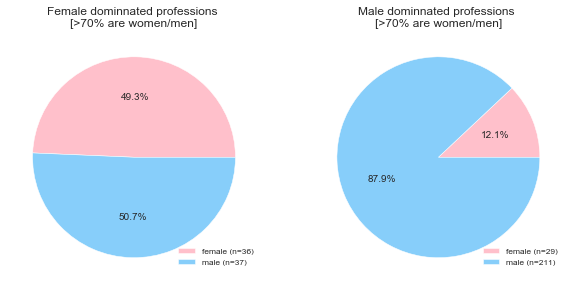

Plots with 'gender is not recognizable' option 


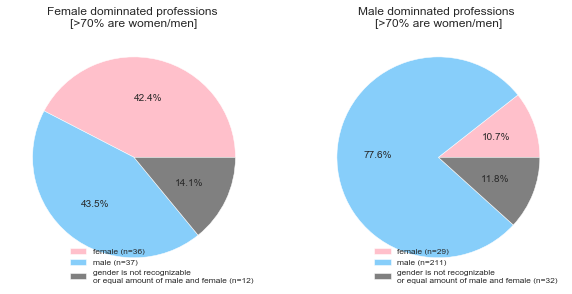

Plots with 'gender is not recognizable' and 'no person' options 
Amount of articles in each group[f m]: 44 166


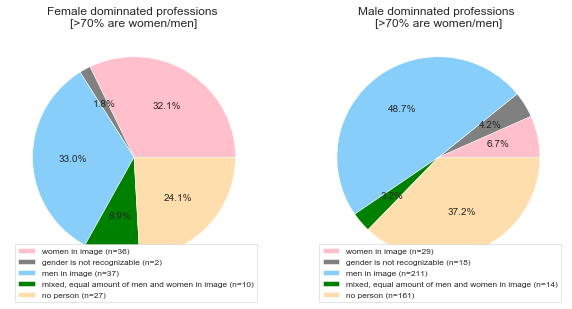

Amount of articles in each group[f m]: 26 137


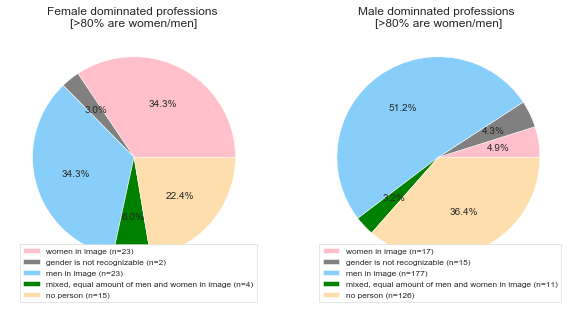

Amount of articles in each group[f m]: 14 96


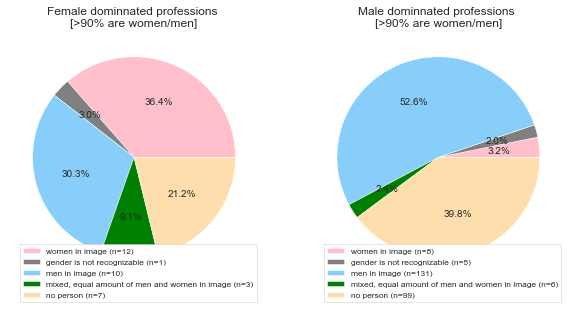

Amount of articles in each group[f m]: 6 62


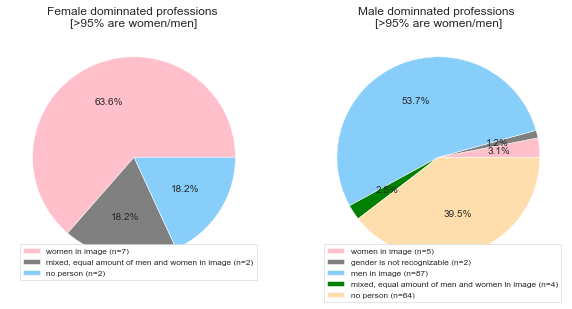

In [27]:
groups=df_images_and_all_onlyfm.groupby("labor_market70_30")
print "Amount of data in each group:",groups.size()
f = plt.figure(figsize=(10,4.5)) 
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size().drop(["gender is not recognizable",
                                                                   "mixed, equal amount of male and female"])
    ax1 = plt.subplot(1,len(groups),i)
    colors = ['pink','lightskyblue']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    ax1.set_title(group_name.title()+" dominnated professions \n[>70% are women/men]", fontsize=12)    
    i+=1
plt.show()

print "Plots with 'gender is not recognizable' option "
f = plt.figure(figsize=(10,4.5)) 
i=1
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    singular["gender is not recognizable\nor equal amount of male and female"]= singular['gender is not recognizable']\
        + singular['mixed, equal amount of male and female']
    singular.drop(["gender is not recognizable","mixed, equal amount of male and female"],inplace=True)
    ax1 = plt.subplot(1,len(groups),i)
    colors = ['pink','grey','lightskyblue','green']
    colors = ['pink','lightskyblue','grey']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    ax1.set_title(group_name.title()+" dominnated professions \n[>70% are women/men]", fontsize=12)    
    i+=1
plt.show()


def plot_gender_dif(name_of_column,ratio):
    groups=df_images_and_all_andnopers.groupby(name_of_column)
    d=df_images_and_all_andnopers
    print "Amount of articles in each group[f m]:",len(d[d[name_of_column]=="female"].profession.unique()),\
                                            len(d[d[name_of_column]=="male"].profession.unique())
    f = plt.figure(figsize=(10,4.5)) 
    i=1
    for group_name, df_group in groups:
        singular=df_group.groupby('Image type simple').size()
        colors=['pink',"grey",'lightskyblue',"green",'navajowhite']
        ax1 = plt.subplot(1,len(groups),i)
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
        new_names=[s.replace('male and female' , 'men and women in image').replace('female' ,
                'women in image').replace('male' , 'men in image') for s in singular.index.values]
        ax1.legend(new_names+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
               bbox_to_anchor=(1, 0.17),frameon=True)
        ax1.set_title(group_name.title()+" dominnated professions \n[>"+ratio+"% are women/men]", fontsize=12)    
        i+=1
    plt.savefig("de/plots/images_domin"+ratio+".png",dpi=500,bbox_inches='tight')
    plt.show()
    
    
print "Plots with 'gender is not recognizable' and 'no person' options "
plot_gender_dif("labor_market70_30","70")
plot_gender_dif("labor_market80_20","80")
plot_gender_dif("labor_market90_10","90")
plot_gender_dif("labor_market95_5","95")

Amount of data in each group: labor_market_domin
female    202
male      389
dtype: int64


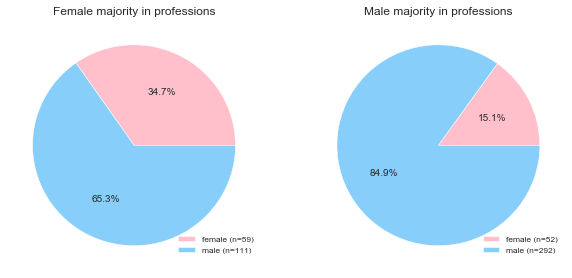

Plots with 'gender is not recognizable' option 


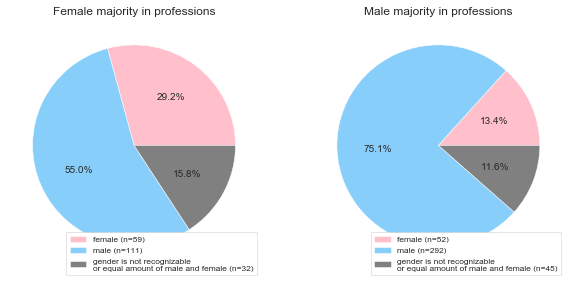

Plots with 'gender is not recognizable' and 'no person' options 


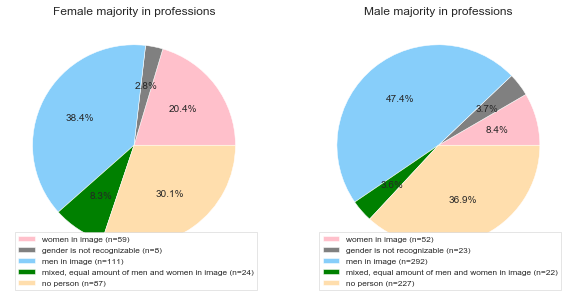

In [21]:
groups=df_images_and_all_onlyfm.groupby("labor_market_domin")
print "Amount of data in each group:",groups.size()
f = plt.figure(figsize=(10,4.5)) 
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size().drop(["gender is not recognizable",
                                                                   "mixed, equal amount of male and female"])
    ax1 = plt.subplot(1,len(groups),i)
    colors = ['pink','lightskyblue']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    ax1.set_title(group_name.title()+" majority in professions", fontsize=12)    
    i+=1
plt.show()

print "Plots with 'gender is not recognizable' option "
f = plt.figure(figsize=(10,4.5)) 
i=1
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    singular["gender is not recognizable\nor equal amount of male and female"]= singular['gender is not recognizable'] + singular['mixed, equal amount of male and female']
    singular.drop(["gender is not recognizable","mixed, equal amount of male and female"],inplace=True)
    ax1 = plt.subplot(1,len(groups),i)
    colors = ['pink','grey','lightskyblue','green']
    colors = ['pink','lightskyblue','grey']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17),frameon=True)
    ax1.set_title(group_name.title()+" majority in professions", fontsize=12)    
    i+=1
plt.show()


print "Plots with 'gender is not recognizable' and 'no person' options "
groups=df_images_and_all_andnopers.groupby("labor_market_domin")
f = plt.figure(figsize=(10,4.5)) 
i=1
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    #singular["gender is not recognizable\nor equal amount of male and female"]= singular['gender is not recognizable'] + singular['mixed, equal amount of male and female']
    #singular.drop(["gender is not recognizable","mixed, equal amount of male and female"],inplace=True)
    colors=['pink',"grey",'lightskyblue',"green",'navajowhite']
    ax1 = plt.subplot(1,len(groups),i)
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    new_names=[s.replace('male and female' , 'men and women in image').replace('female' ,
                'women in image').replace('male' , 'men in image') for s in singular.index.values]
    new_names=new_names+singular.apply(lambda x:" (n="+str(int(x))+")").values
    ax1.legend(new_names,fontsize='small',
           bbox_to_anchor=(1, 0.17),frameon=True)
    ax1.set_title(group_name.title()+" majority in professions", fontsize=12)    
    
    i+=1
plt.savefig("de/image_majority.png",dpi=500)    
plt.show()

In [163]:
from scipy.stats import chi2_contingency
#all values
t=pd.crosstab(df_images_and_all_onlyfm.labor_market_domin,df_images_and_all_onlyfm["Image type simple"],margins=False)
#only male/female values
t2 = t.drop(['gender is not recognizable','mixed, equal amount of male and female'], 1)
t3=t.iloc[:,:3]
t3["gender is not recognizable\nor equal amount of male and female"]= t['gender is not recognizable'] \
+ t['mixed, equal amount of male and female']
t3.drop(["gender is not recognizable"],1,inplace=True)
print chi2_contingency(t,lambda_="log-likelihood")[:3]
print chi2_contingency(t2,lambda_="log-likelihood")[:3]

t4=pd.crosstab(df_images_and_all_andnopers.labor_market_domin,df_images_and_all_andnopers["Image type simple"])
print chi2_contingency(t4,lambda_="log-likelihood")[:3]

t5=pd.crosstab(df_images_and_all_andnopers.labor_market70_30,df_images_and_all_andnopers["Image type simple"])
print chi2_contingency(t5,lambda_="log-likelihood")[:3]#70 to 30

(32.175805446773246, 4.8054657492230703e-07, 3L)
(23.551334597755108, 1.2162503491714182e-06, 1L)
(36.178040684658512, 2.6596342868752704e-07, 4L)
(55.012095510961551, 3.2300723428901883e-11, 4L)


In [164]:
t5

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female",no person
labor_market70_30,,,,,
female,36,2,37,10,27
male,29,18,211,14,161


In [76]:
t

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female"
labor_market_domin,,,,
female,59,8,111,24
male,52,23,292,22


In [75]:
t3

Image type simple,female,male,gender is not recognizable or equal amount of male and female
labor_market_domin,,,
female,59,111,32
male,52,292,45


In [77]:
t2

Image type simple,female,male
labor_market_domin,,
female,59,111
male,52,292


> x <- cbind(A=c(59,111),B=c(52,292))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 25.787, df = NA, p-value = 1e-05

> x <- cbind(A=c(59,8,111,24),B=c(52,23,292,22))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 33.238, df = NA, p-value = 1e-05

> x <- cbind(A=c(59,111,32),B=c(52,292,45))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 27.515, df = NA, p-value = 1e-05

When examining the assocoation between dominated gender in profession and gender of major persons at article images, a chi-square test of independence revealed that among professions that are described on Wikipedia, those where men dominate on labour market were more likely to have more male images at article descriptions (84.9%) compared to those where women dominate on labour market (65.3%), X2=25.787, p=1e-05. 

In [60]:
#what image gropus make difference

from statsmodels.sandbox.stats.multicomp import multipletests

p_val=[]
#print "g-val, p-val without correction, degrees of freedom, exp_val:"
for i in range(0,len(t4.loc["male",:].values)):
    g,p,df,exp_v=chi2_contingency([[t4.loc["male",:].values[i],t4.loc["female",:].values[i]],
                                   [sum(t4.loc["male",:].values)-t4.loc["male",:].values[i],
                                    sum(t4.loc["female",:].values)-[t4.loc["female",:].values[i]]]]
                                                       ,lambda_="log-likelihood")
    p_val.append(p)
names_c=t4.columns.values#["female","gender is not recognizable","male","mixed, equal amount of male and female","no person"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "================ image category =========== p-value_old == reject = p-value_corrected"
print "-"*75
for i in range(0,len(t4.loc["male",:].values)):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_val[i],res[0][i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
================ image category =========== p-value_old == reject = p-value_corrected
---------------------------------------------------------------------------
female                                          1.23e-06    True   2.46e-06
gender is not recognizable                      5.78e-01   False   2.31e-01
male                                            1.33e-02    True   8.89e-03
mixed, equal amount of male and female          5.73e-03    True   5.73e-03
no person                                       5.43e-02    True   2.71e-02


In [165]:
#what image gropus make difference

from statsmodels.sandbox.stats.multicomp import multipletests

p_val=[]
#print "g-val, p-val without correction, degrees of freedom, exp_val:"
for i in range(0,len(t5.loc["male",:].values)):
    g,p,df,exp_v=chi2_contingency([[t5.loc["male",:].values[i],t5.loc["female",:].values[i]],
                                   [sum(t5.loc["male",:].values)-t5.loc["male",:].values[i],
                                    sum(t5.loc["female",:].values)-[t5.loc["female",:].values[i]]]]
                                                       ,lambda_="log-likelihood")
    p_val.append(p)
names_c=t5.columns.values#["female","gender is not recognizable","male","mixed, equal amount of male and female","no person"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "================ image category =========== p-value_old == reject = p-value_corrected"
print "-"*75
for i in range(0,len(t4.loc["male",:].values)):
    print "{:<46}  {:<3.2e} {!r:>7}   {:<3.2e}".format(names_c[i],p_val[i],res[0][i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
================ image category =========== p-value_old == reject = p-value_corrected
---------------------------------------------------------------------------
female                                          5.44e-11    True   5.44e-11
gender is not recognizable                      3.37e-01   False   6.74e-02
male                                            3.80e-03    True   1.90e-03
mixed, equal amount of male and female          2.91e-02    True   7.28e-03
no person                                       1.12e-02    True   3.73e-03


## Redirection bias

Amount of data in each group: Bias
female       3
male       548
neutral     44
dtype: int64


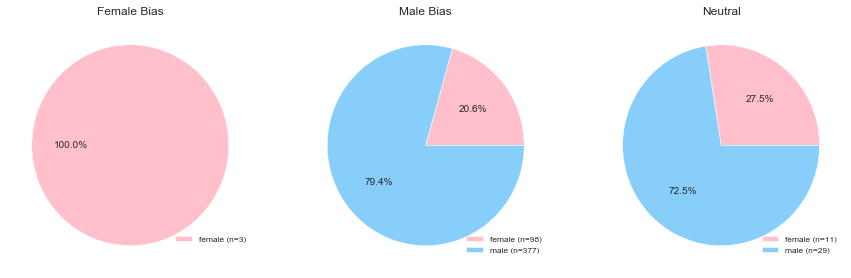

Plots with 'gender is not recognizable' option 


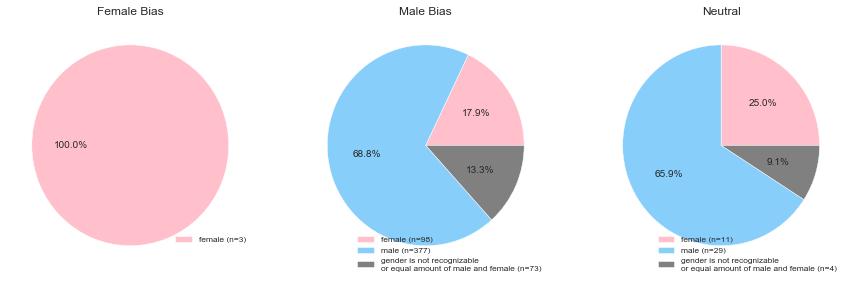

Plots with 'gender is not recognizable' and 'no person' options 
Amount of articles in each group[f m]: 1 320


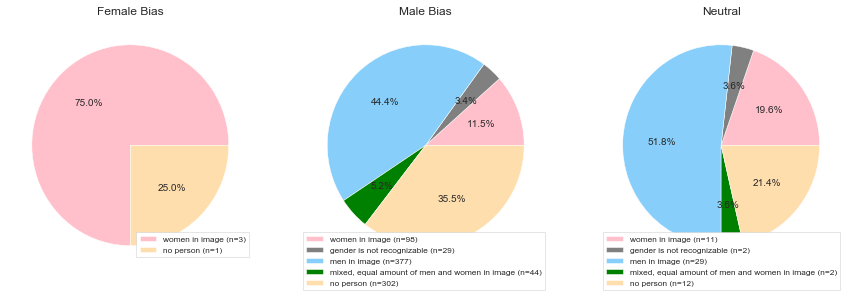

In [25]:
#"Bias"
groups=df_images_and_all_onlyfm.groupby("Bias")
print "Amount of data in each group:",groups.size()
f = plt.figure(figsize=(5*len(groups),4.5)) 
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    if "gender is not recognizable" in singular.index:  
        singular=singular.drop(["gender is not recognizable","mixed, equal amount of male and female"])
    ax1 = plt.subplot(1,len(groups),i) 
    colors = ['pink','lightskyblue']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    if group_name=="neutral":
        ax1.set_title(group_name.title(), fontsize=12) 
    else:
        ax1.set_title(group_name.title()+" Bias", fontsize=12)    
    i+=1
plt.show()

print "Plots with 'gender is not recognizable' option "
f = plt.figure(figsize=(5*len(groups),4.5)) 
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    if "gender is not recognizable" in singular.index:
        singular["gender is not recognizable\nor equal amount of male and female"]= singular['gender is not recognizable'] + singular['mixed, equal amount of male and female']
        singular.drop(["gender is not recognizable","mixed, equal amount of male and female"],inplace=True)
    ax1 = plt.subplot(1,len(groups),i) 
    colors = ['pink','grey','lightskyblue','green']
    colors = ['pink','lightskyblue','grey']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    if group_name=="neutral":
        ax1.set_title(group_name.title(), fontsize=12) 
    else:
        ax1.set_title(group_name.title()+" Bias", fontsize=12)    
    i+=1
plt.show()

def plot_gender_dif(name_of_column):
    groups=df_images_and_all_andnopers.groupby(name_of_column)
    d=df_images_and_all_andnopers
    print "Amount of articles in each group[f m]:",len(d[d[name_of_column]=="female"].profession.unique()),\
                                            len(d[d[name_of_column]=="male"].profession.unique())
    f = plt.figure(figsize=(15,4.5)) 
    i=1
    for group_name, df_group in groups:
        singular=df_group.groupby('Image type simple').size()
        colors=['pink',"grey",'lightskyblue',"green",'navajowhite']
        if len(singular)==2:
            colors=['pink','navajowhite']
        ax1 = plt.subplot(1,len(groups),i)
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
        new_names=[s.replace('male and female' , 'men and women in image').replace('female' ,
                'women in image').replace('male' , 'men in image') for s in singular.index.values]
        ax1.legend(new_names+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
               bbox_to_anchor=(1, 0.17),frameon=True)
        if group_name=="neutral":
            ax1.set_title(group_name.title(), fontsize=12) 
        else:
            ax1.set_title(group_name.title()+" Bias", fontsize=12)      
        i+=1
    plt.savefig("de/plots/images_bias.png",dpi=500,bbox_inches='tight')
    plt.show()
    
print "Plots with 'gender is not recognizable' and 'no person' options "
plot_gender_dif("Bias")

In [141]:
#all values
t=pd.crosstab(df_images_and_all_onlyfm.Bias,df_images_and_all_onlyfm["Image type simple"],margins=False)
#only male/female values
t2 = t.drop(['gender is not recognizable','mixed, equal amount of male and female'], 1)
print chi2_contingency(t,lambda_="log-likelihood")[:3]
print chi2_contingency(t2,lambda_="log-likelihood")[:3]
#!!! a lot of 0's, we should use Monte Carlo simulation of p-val

t3=t.iloc[:,:3]
t3["gender is not recognizable\nor equal amount of male and female"]= t['gender is not recognizable'] \
+ t['mixed, equal amount of male and female']
t3.drop(["gender is not recognizable"],1,inplace=True)

t4=pd.crosstab(df_images_and_all_andnopers.Bias,df_images_and_all_andnopers["Image type simple"])
print chi2_contingency(t4,lambda_="log-likelihood")[:3]

(11.937317062197357, 0.063381882048845553, 6L)
(10.235769348104087, 0.0059886775109013147, 2L)
(17.079868839041886, 0.029288074180716255, 8L)


In [80]:
t

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female"
Bias,,,,
female,3,0,0,0
male,98,29,377,44
neutral,11,2,29,2


In [81]:
t3

Image type simple,female,male,gender is not recognizable or equal amount of male and female
Bias,,,
female,3,0,0
male,98,377,73
neutral,11,29,4


In [142]:
t4

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female",no person
Bias,,,,,
female,3,0,0,0,1
male,98,29,377,44,302
neutral,11,2,29,2,12


for t4

> x <- cbind(A=c(3,0,0,0,1),B=c(92,29,377,44,302),C=c(11,2,29,2,12))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 23.378, df = NA, p-value = 0.01527

for t2

> x <- cbind(A=c(3,0),B=c(92,377),C=c(11,29))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 12.954, df = NA, p-value = 0.00362

> x <- cbind(A=c(3,0,0),B=c(92,377,73),C=c(11,29,4))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 15.872, df = NA, p-value = 0.00608

> x <- cbind(A=c(3,0,0,0),B=c(92,29,377,44),C=c(11,2,29,2))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 15.99, df = NA, p-value = 0.03373

#===========

> x <- cbind(A=c(3,0),B=c(92,377))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 11.981, df = NA, p-value = 0.00763

> 
> x <- cbind(A=c(3,0),B=c(11,29))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 6.6804, df = NA, p-value = 0.02913

> 
> x <- cbind(A=c(92,377),B=c(11,29))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 1.4192, df = NA, p-value = 0.3011

#==============

> x <- cbind(A=c(3,0,0,0),B=c(92,29,377,44))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 14.289, df = NA, p-value = 0.018

> 
> x <- cbind(A=c(3,0,0,0),B=c(11,2,29,2))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 7.5536, df = NA, p-value = 0.06258

> 
> x <- cbind(A=c(92,29,377,44),B=c(11,2,29,2))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 2.2812, df = NA, p-value = 0.5309

In [22]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.3011,  0.00763, 0.02913]
names_c=["male and neutral ","female and male","female and neutral"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
male and neutral               False     3.01e-01    1.00e-01
female and male                True      7.63e-03    7.63e-03
female and neutral             True      2.91e-02    1.46e-02


A Chi square test ofindependence revealed that among professins described on Wikipedia, proportion of female/male images and  redirection bias category of profession were significantly associated (X-squared = 12.954, p=0.00362).

Post hoc comparison of female/male images proportion by pairs of redirection bias categories revealed that higher proportion of male images were seen among those professions, that are in male bias (p=7.63e-03) and neutral (p=1.46e-02) category, compare to female bias group. In comparison, prevalence of male images was statistically similar among male bias and neutral profession groups. 

In [4]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.5297,  0.01797, 0.06075]
names_c=["male and neutral ","female and male","female and neutral"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.1, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])
print res[1]


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
male and neutral               False     5.30e-01    1.77e-01
female and male                True      1.80e-02    1.80e-02
female and neutral             True      6.07e-02    3.04e-02
[ 0.17656667  0.01797     0.030375  ]


group "gender is not recognisable" and "mixed, equal amount of male and female" together

> x <- cbind(A=c(3,0,0),B=c(92,377,73))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 14.289, df = NA, p-value = 0.00741

> 
> x <- cbind(A=c(3,0,0),B=c(11,29,4))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 7.5536, df = NA, p-value = 0.03929

> 
> x <- cbind(A=c(92,377,73),B=c(11,29,4))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 2.1631, df = NA, p-value = 0.3608

In [6]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.3608,  0.00741, 0.03929]
names_c=["male and neutral ","female and male","female and neutral"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])
print res[1]


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
male and neutral               False     3.61e-01    2.41e-01
female and male                True      7.41e-03    1.48e-02
female and neutral             True      3.93e-02    3.93e-02
[ 0.24053333  0.01482     0.03929   ]


for t4

> x <- cbind(A=c(3,0,0,0,1),B=c(92,29,377,44,302))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 16.863, df = NA, p-value = 0.01896

> 
> x <- cbind(A=c(3,0,0,0,1),B=c(11,2,29,2,12))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 7.2822, df = NA, p-value = 0.1539

> 
> x <- cbind(A=c(92,29,377,44,302),B=c(11,2,29,2,12))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 7.4777, df = NA, p-value = 0.1076


In [143]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.1076,  0.01896, 0.1539]
names_c=["male and neutral ","female and male","female and neutral"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])
print res[1]


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
male and neutral               False     1.08e-01    1.54e-01
female and male                False     1.90e-02    5.69e-02
female and neutral             False     1.54e-01    1.54e-01
[ 0.1539   0.05688  0.1539 ]


In [146]:
t4

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female",no person
Bias,,,,,
female,3,0,0,0,1
male,98,29,377,44,302
neutral,11,2,29,2,12


In [159]:
for i in t4.columns:
    print t4[i].values,[sum(t4.iloc[0])-t4[i][0],sum(t4.iloc[1])-t4[i][1],sum(t4.iloc[2])-t4[i][2]]

[ 3 98 11] [1, 752, 45]
[ 0 29  2] [4, 821, 54]
[  0 377  29] [4, 473, 27]
[ 0 44  2] [4, 806, 54]
[  1 302  12] [3, 548, 44]


> x <- cbind(A=c(3,98,11),B=c(1,752,45))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 17.835, df = NA, p-value = 0.00094

> 
> x <- cbind(A=c(0,29,2),B=c(4,821,54))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.14576, df = NA, p-value = 1

> 
> x <- cbind(A=c(0,377,29),B=c(4,473,27))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 4.4111, df = NA, p-value = 0.1125

> 
> x <- cbind(A=c(0,44,2),B=c(4,806,54))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.49591, df = NA, p-value = 0.8084

> 
> x <- cbind(A=c(1,302,12),B=c(3,548,44))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 4.7797, df = NA, p-value = 0.07306


In [10]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.00094, 1, 0.1125,  0.8084, 0.07306]
#names_c=t4.columns
names_c=["female","gender is not recognizable","male ","mixed, equal amount of male and female","no person"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<38}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])
print res[1]


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
female                                  True      9.40e-04    3.76e-03
gender is not recognizable              False     1.00e+00    8.00e-01
male                                    False     1.13e-01    1.50e-01
mixed, equal amount of male and female  False     8.08e-01    8.00e-01
no person                               False     7.31e-02    1.46e-01
[ 0.00376  0.8      0.15     0.8      0.14612]


## Group by gender of profession name

Amount of data in each group: prof_gender
female      12
male       558
neutral     25
dtype: int64


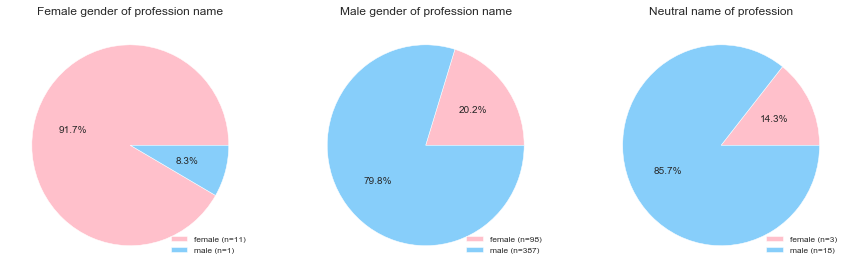

Plots with 'gender is not recognizable' option 


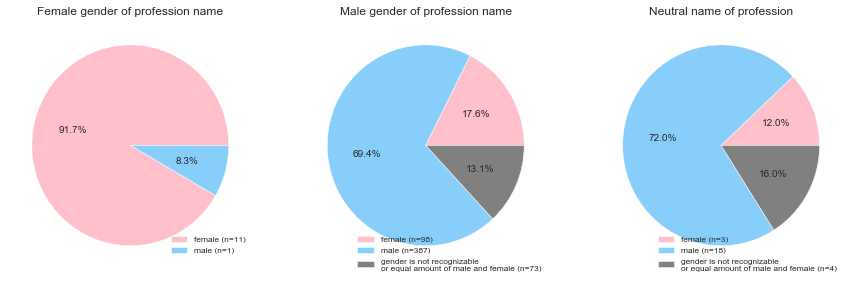

Plots with 'gender is not recognizable' and 'no person' option 


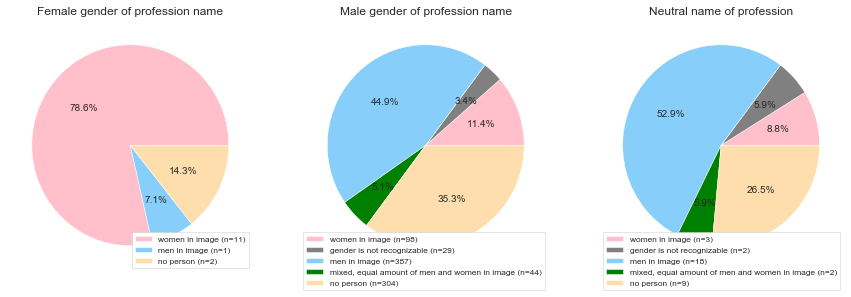

In [26]:
groups=df_images_and_all_onlyfm.groupby("prof_gender")
print "Amount of data in each group:",groups.size()
f = plt.figure(figsize=(5*len(groups),4.5)) 
data2={}
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    if "gender is not recognizable" in singular.index:  
        singular=singular.drop(["gender is not recognizable","mixed, equal amount of male and female"])
    ax1 = plt.subplot(1,len(groups),i)
    colors = ['pink','lightskyblue']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    if group_name=="neutral":
        ax1.set_title(group_name.title()+" name of profession", fontsize=12) 
    else:
        ax1.set_title(group_name.title()+" gender of profession name", fontsize=12)    
    data2[group_name]=singular
    i+=1
plt.show()

print "Plots with 'gender is not recognizable' option "
f = plt.figure(figsize=(5*len(groups),4.5)) 
data2={}
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    if "gender is not recognizable" in singular.index: 
        singular["gender is not recognizable\nor equal amount of male and female"]= singular['gender is not recognizable']\
        + singular['mixed, equal amount of male and female']
        singular=singular.drop(["gender is not recognizable","mixed, equal amount of male and female"])
    ax1 = plt.subplot(1,len(groups),i)
    colors = ['pink','grey','lightskyblue','green']
    colors = ['pink','lightskyblue','grey']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    ax1.legend(singular.index.values+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17))
    if group_name=="neutral":
        ax1.set_title(group_name.title()+" name of profession", fontsize=12) 
    else:
        ax1.set_title(group_name.title()+" gender of profession name", fontsize=12)    
    data2[group_name]=singular
    i+=1
plt.show()

print "Plots with 'gender is not recognizable' and 'no person' option "
groups=df_images_and_all_andnopers.groupby("prof_gender")
f = plt.figure(figsize=(5*len(groups),4.5)) 
data2={}
i=1    
for group_name, df_group in groups:
    singular=df_group.groupby('Image type simple').size()
    ax1 = plt.subplot(1,len(groups),i)
    colors=['pink',"grey",'lightskyblue',"green",'navajowhite']
    if len(singular)==3:
        colors=['pink','lightskyblue','navajowhite']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%')
    new_names=[s.replace('male and female' , 'men and women in image').replace('female' ,
                'women in image').replace('male' , 'men in image') for s in singular.index.values]
    ax1.legend(new_names+singular.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',
           bbox_to_anchor=(1, 0.17),frameon=True)
    if group_name=="neutral":
        ax1.set_title(group_name.title()+" name of profession", fontsize=12) 
    else:
        ax1.set_title(group_name.title()+" gender of profession name", fontsize=12)    
    data2[group_name]=singular
    i+=1
plt.savefig("de/plots/images_gender.png",dpi=500)
plt.show()

In [168]:
#all values
t=pd.crosstab(df_images_and_all_onlyfm.prof_gender,df_images_and_all_onlyfm["Image type simple"],margins=False)
#only male/female values
t2 = t.drop(['gender is not recognizable','mixed, equal amount of male and female'], 1)
print chi2_contingency(t,lambda_="log-likelihood")[:3]
print chi2_contingency(t2,lambda_="log-likelihood")[:3]
#!!! some values are <5, we should use Monte Carlo simulation of p-val

t3=t.iloc[:,:3]
t3["gender is not recognizable\nor equal amount of male and female"]= t['gender is not recognizable'] \
+ t['mixed, equal amount of male and female']
t3.drop(["gender is not recognizable"],1,inplace=True)


t4=pd.crosstab(df_images_and_all_andnopers.prof_gender,df_images_and_all_andnopers["Image type simple"])
t4

(32.307306432470462, 1.4246698962390642e-05, 6L)
(28.612803267779835, 6.1208074069859185e-07, 2L)


Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female",no person
prof_gender,,,,,
female,11,0,1,0,2
male,98,29,387,44,304
neutral,3,2,18,2,9


> x <- cbind(A=c(11,0,1,0,2),B=c(98,29,387,44,304),C=c(3,2,18,2,9))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 60.129, df = NA, p-value = 3e-05


> x <- cbind(A=c(11,0,1,0,2),B=c(98,29,387,44,304))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 57.356, df = NA, p-value = 1e-05

> 
> x <- cbind(A=c(11,0,1,0,2),B=c(3,2,18,2,9))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 24.085, df = NA, p-value = 3e-05

> 
> x <- cbind(A=c(98,29,387,44,304),B=c(3,2,18,2,9))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 2.019, df = NA, p-value = 0.7438

In [169]:
for i in t4.columns:
    print t4[i].values,[sum(t4.iloc[0])-t4[i][0],sum(t4.iloc[1])-t4[i][1],sum(t4.iloc[2])-t4[i][2]]

[11 98  3] [3, 764, 31]
[ 0 29  2] [14, 833, 32]
[  1 387  18] [13, 475, 16]
[ 0 44  2] [14, 818, 32]
[  2 304   9] [12, 558, 25]


> x <- cbind(A=c(11,98,3),B=c(3,764,31))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 58.043, df = NA, p-value = 1e-05

> x <- cbind(A=c(0,29,2),B=c(14,833,32))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 1.1318, df = NA, p-value = 0.6536

> x <- cbind(A=c(1,387,18),B=c(13,475,16))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 8.9369, df = NA, p-value = 0.00911

> x <- cbind(A=c(0,44,2),B=c(14,818,32))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.79826, df = NA, p-value = 0.785

> x <- cbind(A=c(2,304,9),B=c(12,558,25))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 3.7147, df = NA, p-value = 0.1518

In [170]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 1e-05, 0.6536, 0.00911,  0.785, 0.1518]
names_c=t4.columns
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<38}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])
print res[1]


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
female                                  True      1.00e-05    3.00e-05
gender is not recognizable              False     6.54e-01    4.71e-01
male                                    True      9.11e-03    1.37e-02
mixed, equal amount of male and female  False     7.85e-01    4.71e-01
no person                               False     1.52e-01    1.52e-01
[  3.00000000e-05   4.71000000e-01   1.36650000e-02   4.71000000e-01
   1.51800000e-01]


In [91]:
t

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female"
prof_gender,,,,
female,11,0,1,0
male,98,29,387,44
neutral,3,2,18,2


In [92]:
t3

Image type simple,female,male,gender is not recognizable or equal amount of male and female
prof_gender,,,
female,11,1,0
male,98,387,73
neutral,3,18,4


> x <- cbind(A=c(11,1),B=c(98,387),C=c(3,18))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 35.982, df = NA, p-value = 1e-05

> 
> x <- cbind(A=c(11,0,1,0),B=c(98,29,387,44),C=c(3,2,18,2))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 43.327, df = NA, p-value = 5e-05

> x <- cbind(A=c(11,1,0),B=c(98,387,73),C=c(3,18,4))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 43.123, df = NA, p-value = 1e-05

According to the results category of image and gender of profession name are not independent. Thus, a signifficant difference (p=1e-05) exists in a distribution of image categories among different genders of profession name. 

check which categories has signifficant difference

> x <- cbind(A=c(11,1),B=c(98,387))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 34.926, df = NA, p-value = 1e-05

> 
> x <- cbind(A=c(11,1),B=c(3,18))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 18.72, df = NA, p-value = 4e-05

> 
> x <- cbind(A=c(98,387),B=c(3,18))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05 replicates)

data:  x
X-squared = 0.44162, df = NA, p-value = 0.5961

In [148]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.5961,  1e-05, 4e-05]
names_c=["male and neutral ","female and male","female and neutral"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
male and neutral               False     5.96e-01    1.99e-01
female and male                True      1.00e-05    1.00e-05
female and neutral             True      4.00e-05    2.00e-05


According to the results a signifficant difference exists between categories: female and male gender of profession name (p=1e-05); female and neutral profession name (p=2e-05). There is no signifficant difference between categories male gender and neutral name of profession.


> x <- cbind(A=c(11,1,0),B=c(98,387,73))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 41.73, df = NA, p-value = 1e-05

> 
> x <- cbind(A=c(11,1,0),B=c(3,18,4))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 21.92, df = NA, p-value = 1e-05

> 
> x <- cbind(A=c(98,387,73),B=c(3,18,4))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.60571, df = NA, p-value = 0.8199

In [101]:
from statsmodels.sandbox.stats.multicomp import multipletests
p_all=[ 0.8199,  1e-05, 1e-05]
names_c=["male and neutral ","female and male","female and neutral"]
print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "======================= reject null-hyp.| p_val_old | p_val_corrected"
print "-"*75
for i in range(0,len(p_all)):
    print "{:<29}  {!r:<9} {:<11.2e} {:>7.2e}".format(names_c[i],res[0][i],p_all[i],res[1][i])
res[1]


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
======================= reject null-hyp.| p_val_old | p_val_corrected
---------------------------------------------------------------------------
male and neutral               False     8.20e-01    2.73e-01
female and male                True      1.00e-05    5.00e-06
female and neutral             True      1.00e-05    5.00e-06


array([  2.73300000e-01,   5.00000000e-06,   5.00000000e-06])

## additional notes:

In [ ]:
#If data are not normally distributed -> use  Box-Cox power transformation of data

In [ ]:
from scipy.stats.distributions import chi2
#===== manual calculation of p-val
def ttes(T):
    PR = T.sum(1) / float(T.sum())
    PC = T.sum(0) / float(T.sum())
    E = np.outer(PR, PC)
    C = T.sum()*E
    cs = ((T-C)**2/C).sum()
    df = (T.shape[0]-1)*(T.shape[1]-1)
    pvalue = 1 - chi2.cdf(cs, df)
    #print cs,pvalue,df
    return cs,pvalue,df,E
#===================

from scipy import stats
oddsratio, pvalue = stats.fisher_exact([[65, 18], [7, 1]])
print oddsratio,pvalue
oddsratio, pvalue = stats.fisher_exact([[237, 11], [17, 1]])
print oddsratio,pvalue

#from http://stats.stackexchange.com/questions/135796/is-the-chi-squared-test-appropriate-with-many-small-counts-in-a-5x2-table
#Fisher's exact test
#scipy.stats.fisher_exact(table, alternative='two-sided')
#Performs a Fisher exact test on a 2x2 contingency table.
#http://vassarstats.net/fisher2x3.html
#http://stats.stackexchange.com/questions/14226/given-the-power-of-computers-these-days-is-there-ever-a-reason-to-do-a-chi-squa/14230#14230
#https://www.mrnoutahi.com/2016/01/03/Fisher-exac-test-for-mxn-table/

#Other solutions:
#1)Simulating the Chi-squared P-value
#One way to check is to simulate the true distribution of the χ2 statistic. R offers a "Monte Carlo" test.
#chisq.test(x, simulate.p.value=TRUE, B=1e5)
#2)Another approach is to bootstrap the test


TODO???: all posible pairswise comparosions of rows and all posible pairswise comparosions of columns
in order to see if the image categories are equally likely under each row.

"Ho: the image categories distributed equally", for each row [ gender that dominate in profession].

In [17]:
#Example of cross-tab
pd.crosstab(df_images_and_all_onlyfm.labor_market_domin,
            df_images_and_all_onlyfm["Image type simple"], margins = True)

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female",All
labor_market_domin,,,,,
female,59,8,111,24,202
male,52,23,292,22,389
All,112,31,406,46,595


In [28]:
prof_aggr=pd.crosstab(df_images_and_all_andnopers.profession,df_images_and_all_andnopers["Image type simple"])#283
prof_notrecogn_and_mixed=prof_aggr[(prof_aggr.female==0)&(prof_aggr.male==0)]#21
prof_aggr=prof_aggr[~((prof_aggr.female==0)&(prof_aggr.male==0))]#262
prof_aggr["dif_m_f"]=(prof_aggr.male-prof_aggr.female)/(prof_aggr.male+prof_aggr.female+\
                    prof_aggr["gender is not recognizable"]+prof_aggr["mixed, equal amount of male and female"])
prof_aggr["dif_m_f2"]=(prof_aggr.male-prof_aggr.female)/(prof_aggr.male+prof_aggr.female+\
        prof_aggr["gender is not recognizable"]+prof_aggr["mixed, equal amount of male and female"]+prof_aggr["no person"])
prof_aggr["percentage_m"]=(prof_aggr.male)/(prof_aggr.male+prof_aggr.female+\
                    prof_aggr["gender is not recognizable"]+prof_aggr["mixed, equal amount of male and female"])
prof_aggr["percentage_f"]=(prof_aggr.female)/(prof_aggr.male+prof_aggr.female+\
                    prof_aggr["gender is not recognizable"]+prof_aggr["mixed, equal amount of male and female"])
#read file 
df_about_pages=pd.read_csv('de/all_data_bias_labour_gender_all_persons.csv',sep='\t', encoding='utf-8',index_col=0)
about_pages_=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)
df_about_pages["labor_market_women_ratio"]=df_about_pages.apply(lambda x: about_pages_.loc[x.profession,"labor_market_woman"],
                                                                axis=1)
df_about_pages.loc[:,'f_m_all_amount'] = df_about_pages['male_all_amount']+ df_about_pages['female_all_amount']
df_about_pages.loc[:,"m_normalized"]=df_about_pages.apply(lambda x:float(x["male_all_amount"])/float(x['f_m_all_amount']) if float(x['f_m_all_amount'])>0 else None,axis=1)

df_copy=df_about_pages[["male_all_amount","female_all_amount","f_m_all_amount","m_normalized","labor_market_women_ratio","profession",
            "Bias","prof_gender","labor_market_domin","labor_market_all"]]
df_copy=df_copy.rename(columns = {"male_all_amount":"men","female_all_amount":"women",'f_m_all_amount':'all_persons',
                        "m_normalized":"men_ratio"})
df_copy["labor_market_women"]=df_copy["labor_market_women_ratio"]*df_copy["labor_market_all"]/100
df_copy["labor_market_men"]=df_copy["labor_market_all"]-df_copy["labor_market_women"]


df_copy2=pd.read_csv('de/all_persons_and_labor_market.csv',sep='\t', encoding='utf-8',index_col=0)#411

#add_column# intersection with df_copy2  is only 181
df_copy2["image_dif"]=df_copy2.apply(lambda x: prof_aggr.dif_m_f[x.profession] if x.profession in prof_aggr.index else None,
                                     axis=1)
df_copy["image_dif"]=df_copy.apply(lambda x:prof_aggr.dif_m_f[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
df_copy2["percentage_m"]=df_copy2.apply(lambda x:prof_aggr.percentage_m[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
df_copy["percentage_m"]=df_copy.apply(lambda x:prof_aggr.percentage_m[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
df_copy2["percentage_f"]=df_copy2.apply(lambda x:prof_aggr.percentage_f[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
df_copy["percentage_f"]=df_copy.apply(lambda x:prof_aggr.percentage_f[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
#df_copy["image_dif2"]=df_copy.apply(lambda x: prof_aggr.dif_m_f2[x.profession] if x.profession in prof_aggr.index else None,
#                                   axis=1)

df_copy["image_women"]=df_copy.apply(lambda x: prof_aggr.female[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
df_copy["image_men"]=df_copy.apply(lambda x: prof_aggr.male[x.profession] if x.profession in prof_aggr.index else None,
                                   axis=1)
#print pd.isnull(df_copy).sum()
#print pd.isnull(df_copy2).sum()
#df_copy.dropna(inplace=True)
#print len(df_copy)
df_copy.corr(method='pearson')

,men,women,all_persons,men_ratio,labor_market_women_ratio,labor_market_all,labor_market_women,labor_market_men,image_dif,percentage_m,percentage_f,image_women,image_men
men,1.000000,0.394776,0.975587,0.110140,0.051486,-0.052042,-0.043098,-0.046605,0.005664,0.007506,-0.003484,0.147040,0.270745
women,0.394776,1.000000,0.586912,-0.289538,0.134363,-0.010558,0.011861,-0.038285,-0.165641,-0.152995,0.173251,0.323706,0.072343
all_persons,0.975587,0.586912,1.000000,0.025449,0.077503,-0.048389,-0.035145,-0.050227,-0.049544,-0.043879,0.053840,0.227687,0.247777
men_ratio,0.110140,-0.289538,0.025449,1.000000,-0.218425,-0.213119,-0.232087,-0.119967,0.355204,0.329902,-0.369548,-0.384159,0.166853
labor_market_women_ratio,0.051486,0.134363,0.077503,-0.218425,1.000000,0.124696,0.300319,-0.164048,-0.345903,-0.326832,0.353879,0.350677,-0.140079
labor_market_all,-0.052042,-0.010558,-0.048389,-0.213119,0.124696,1.000000,0.900685,0.794006,-0.163768,-0.152374,0.170084,0.229858,-0.009311
labor_market_women,-0.043098,0.011861,-0.035145,-0.232087,0.300319,0.900685,1.000000,0.451030,-0.271638,-0.252656,0.282201,0.354323,-0.121803
labor_market_men,-0.046605,-0.038285,-0.050227,-0.119967,-0.164048,0.794006,0.451030,1.000000,0.034080,0.031602,-0.035508,-0.012691,0.140692
image_dif,0.005664,-0.165641,-0.049544,0.355204,-0.345903,-0.163768,-0.271638,0.034080,1.000000,0.983837,-0.981365,-0.780577,0.466662
percentage_m,0.007506,-0.152995,-0.043879,0.329902,-0.326832,-0.152374,-0.252656,0.031602,0.983837,1.000000,-0.931094,-0.765398,0.439358


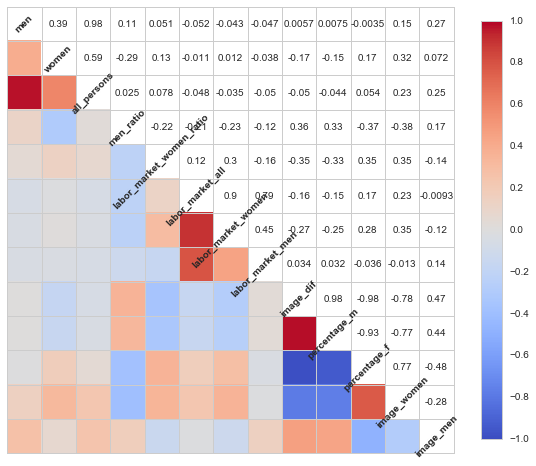

In [44]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.corrplot(df_copy,sig_stars=True)

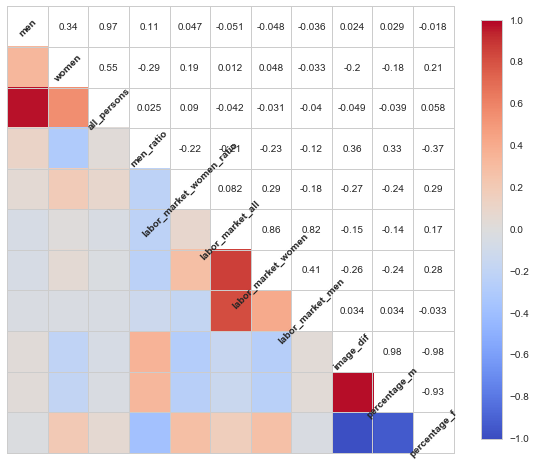

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.corrplot(df_copy2)

In [46]:
df_copy.corr(method='spearman')

,men,women,all_persons,men_ratio,labor_market_women_ratio,labor_market_all,labor_market_women,labor_market_men,image_dif,percentage_m,percentage_f,image_women,image_men
men,1.000000,0.641928,0.979759,-0.097164,0.100230,-0.203202,-0.118221,-0.197304,-0.103664,-0.091424,0.101522,0.166568,0.298028
women,0.641928,1.000000,0.726364,-0.854905,0.186822,-0.097965,0.003510,-0.127923,-0.254912,-0.240670,0.280807,0.339849,0.111976
all_persons,0.979759,0.726364,1.000000,-0.322694,0.117600,-0.188063,-0.096826,-0.186618,-0.142224,-0.128701,0.146160,0.210437,0.265455
men_ratio,-0.097164,-0.854905,-0.322694,1.000000,-0.271342,-0.079568,-0.170091,-0.010440,0.304434,0.291099,-0.345820,-0.365522,0.091785
labor_market_women_ratio,0.100230,0.186822,0.117600,-0.271342,1.000000,0.018933,0.490064,-0.282595,-0.306922,-0.299544,0.339943,0.341765,-0.197579
labor_market_all,-0.203202,-0.097965,-0.188063,-0.079568,0.018933,1.000000,0.849898,0.925454,-0.068450,-0.075362,0.012885,-0.002842,0.029583
labor_market_women,-0.118221,0.003510,-0.096826,-0.170091,0.490064,0.849898,1.000000,0.657450,-0.204360,-0.210086,0.166680,0.153957,-0.068921
labor_market_men,-0.197304,-0.127923,-0.186618,-0.010440,-0.282595,0.925454,0.657450,1.000000,0.024619,0.013407,-0.091446,-0.105036,0.087837
image_dif,-0.103664,-0.254912,-0.142224,0.304434,-0.306922,-0.068450,-0.204360,0.024619,1.000000,0.996447,-0.934343,-0.908814,0.452687
percentage_m,-0.091424,-0.240670,-0.128701,0.291099,-0.299544,-0.075362,-0.210086,0.013407,0.996447,1.000000,-0.914189,-0.891009,0.457905


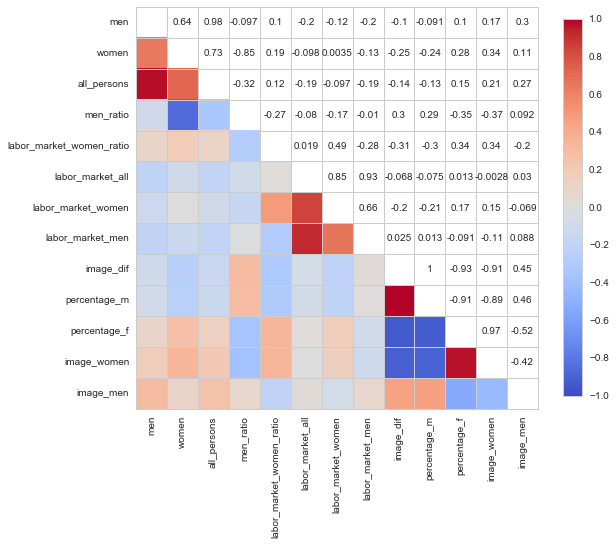

In [47]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_copy,method="spearman",diag_names=False)

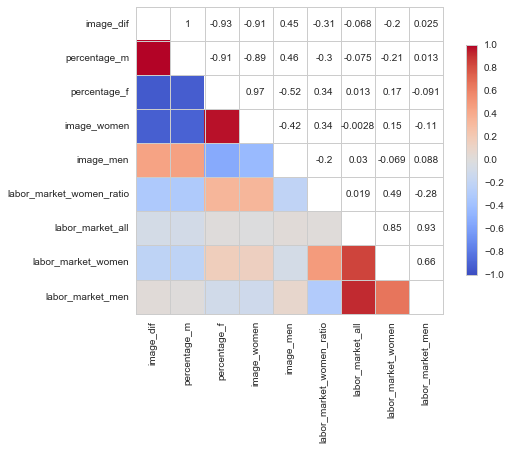

In [49]:
sns.corrplot(df_copy[["image_dif","percentage_m","percentage_f","image_women","image_men","labor_market_women_ratio",
                      "labor_market_all","labor_market_women","labor_market_men"]],method="spearman",diag_names=False)

In [43]:
from scipy.stats import spearmanr
df_copy=df_copy[["image_dif","percentage_m","percentage_f","image_women","image_men","labor_market_women_ratio",
                      "labor_market_all","labor_market_women","labor_market_men"]]
df_copy3=df_copy[~df_copy.isnull().any(axis=1)]
#construct two arrays, one of the correlation and the other of the p-vals
rho = df_copy3.corr(method='spearman')
pval = np.zeros([df_copy3.shape[1],df_copy3.shape[1]])
pval2=np.zeros([df_copy3.shape[1],df_copy3.shape[1]])
cor_s=np.zeros([df_copy3.shape[1],df_copy3.shape[1]])
for i in range(df_copy3.shape[1]): # rows are the number of rows in the matrix.
    for j in range(df_copy3.shape[1]):
        JonI        = pd.ols(y=df_copy3.icol(i), x=df_copy3.icol(j), intercept=True)
        pval[i,j]  = JonI.f_stat['p-value']
        pval2[i,j]= spearmanr(df_copy3.icol(i),df_copy3.icol(j))[1]
        cor_s[i,j]= spearmanr(df_copy3.icol(i),df_copy3.icol(j))[0]

rho


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]


,image_dif,percentage_m,percentage_f,image_women,image_men,labor_market_women_ratio,labor_market_all,labor_market_women,labor_market_men
image_dif,1.000000,0.996388,-0.933719,-0.907933,0.453845,-0.306922,-0.068450,-0.204360,0.024619
percentage_m,0.996388,1.000000,-0.913471,-0.890006,0.459245,-0.299544,-0.075362,-0.210086,0.013407
percentage_f,-0.933719,-0.913471,1.000000,0.972576,-0.526257,0.339943,0.012885,0.166680,-0.091446
image_women,-0.907933,-0.890006,0.972576,1.000000,-0.425415,0.341765,-0.002842,0.153957,-0.105036
image_men,0.453845,0.459245,-0.526257,-0.425415,1.000000,-0.197579,0.029583,-0.068921,0.087837
labor_market_women_ratio,-0.306922,-0.299544,0.339943,0.341765,-0.197579,1.000000,-0.039973,0.494362,-0.307295
labor_market_all,-0.068450,-0.075362,0.012885,-0.002842,0.029583,-0.039973,1.000000,0.799544,0.943184
labor_market_women,-0.204360,-0.210086,0.166680,0.153957,-0.068921,0.494362,0.799544,1.000000,0.624574
labor_market_men,0.024619,0.013407,-0.091446,-0.105036,0.087837,-0.307295,0.943184,0.624574,1.000000


In [48]:
df_cor=pd.DataFrame()
df_cor["feature1"]=["image_dif"]*9+["percentage_m"]*9+["percentage_f"]*9+["image_women"]*9\
                            +["image_men"]*9+["labor_market_women_ratio"]*9+[ "labor_market_all"]*9+\
                            ["labor_market_women"]*9+["labor_market_men"]*9
df_cor["feature2"]=["image_dif","percentage_m","percentage_f","image_women","image_men","labor_market_women_ratio",
                      "labor_market_all","labor_market_women","labor_market_men"]*9


df_cor["cor"]=cor_s.ravel()
df_cor["pval"]=pval2.ravel()
df_cor["pval2"]=df_cor.pval.apply(lambda x:"***"if x<0.001 else"**"if x<0.01else"*"if x<0.05else "."if x<0.1 else "" ) 
df_cor[(~df_cor.feature1.isin(["labor_market_women_ratio","labor_market_all","labor_market_women",
                               "labor_market_men"]))&(~df_cor.feature2.isin(["image_dif","percentage_m","percentage_f",
                                                                             "image_women","image_men"]))]

,feature1,feature2,cor,pval,pval2
5,image_dif,labor_market_women_ratio,-0.306922,4.712493e-07,***
6,image_dif,labor_market_all,-0.068450,2.723955e-01,
7,image_dif,labor_market_women,-0.204360,9.398670e-04,***
8,image_dif,labor_market_men,0.024619,6.933284e-01,
14,percentage_m,labor_market_women_ratio,-0.299544,9.079194e-07,***
15,percentage_m,labor_market_all,-0.075362,2.267843e-01,
16,percentage_m,labor_market_women,-0.210086,6.672101e-04,***
17,percentage_m,labor_market_men,0.013407,8.299784e-01,
23,percentage_f,labor_market_women_ratio,0.339943,1.994917e-08,***
24,percentage_f,labor_market_all,0.012885,8.365044e-01,


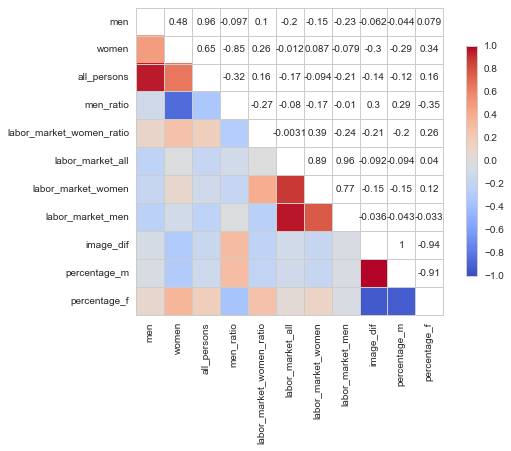

In [51]:
sns.corrplot(df_copy2,method="spearman",diag_names=False)

In [84]:
pd.crosstab(df_images_and_all_andnopers.profession,
            df_images_and_all_andnopers["Image type simple"], margins = True)

Image type simple,female,gender is not recognizable,male,"mixed, equal amount of male and female",no person,All
profession,,,,,,
Abt,0,0,1,0,0,1
Altenpfleger,2,0,0,0,1,3
Amtsanwalt,0,0,0,0,1,1
Apotheker,0,0,2,0,1,3
Architekt,2,1,2,0,1,6
Archivar,0,0,1,0,0,1
Artist (Darsteller),1,0,0,0,0,1
Arzt,0,0,1,0,0,1
Asphaltbauer,0,0,2,0,0,2


In [47]:
df_images_and_all_andnopers[(~df_images_and_all_andnopers.labor_market95_5.isnull())&(df_images_and_all_andnopers.Bias=="female")].profession

320    Hebamme
321    Hebamme
322    Hebamme
323    Hebamme
Name: profession, dtype: object

In [49]:
df_images_and_all_onlyfm[df_images_and_all_onlyfm.prof_gender=="female"].profession

212            Hebamme
213            Hebamme
214            Hebamme
224            Hostess
225            Hostess
226            Hostess
321               Magd
365              Nonne
370    Ordensschwester
371    Ordensschwester
401          Politesse
402          Politesse
Name: profession, dtype: object

In [67]:
df_copy[(df_copy.labor_market_women_ratio>70)&(df_copy.men_ratio>0.6)]

,men,women,all_persons,men_ratio,labor_market_women_ratio,profession,Bias,prof_gender,labor_market_domin,labor_market_all,labor_market_women,labor_market_men,image_dif,image_women,image_men
Altenpflegehelfer,3,1,4,0.750000,85.089472,Altenpflegehelfer,male,male,female,502504,427578,74926,NaN,NaN,NaN
Anästhesietechnischer Assistent,2,1,3,0.666667,77.728520,Anästhesietechnischer Assistent,male,male,female,9474,7364,2110,NaN,NaN,NaN
Apotheker,29,1,30,0.966667,83.810209,Apotheker,neutral,male,female,37536,31459,6077,1.000000,0,2
Arzt,21,3,24,0.875000,90.964370,Arzt,male,male,female,66769,60736,6033,1.000000,0,1
Aufsichtsperson,2,1,3,0.666667,76.993323,Aufsichtsperson,neutral,neutral,female,129106,99403,29703,NaN,NaN,NaN
Augenoptiker,1,0,1,1.000000,76.746654,Augenoptiker,male,male,female,33922,26034,7888,NaN,NaN,NaN
Bewährungshelfer,2,0,2,1.000000,74.955615,Bewährungshelfer,male,male,female,278813,208986,69827,NaN,NaN,NaN
Bibliothekar,22,14,36,0.611111,81.596974,Bibliothekar,male,male,female,23795,19416,4379,1.000000,0,1
Buchhändler,9,2,11,0.818182,83.067762,Buchhändler,male,male,female,11924,9905,2019,NaN,NaN,NaN
Butler,30,13,43,0.697674,93.691910,Butler,male,male,female,190866,178826,12040,0.500000,1,3


In [65]:
df_copy[(df_copy.prof_gender=="female")]

,men,women,all_persons,men_ratio,labor_market_women_ratio,profession,Bias,prof_gender,labor_market_domin,labor_market_all,labor_market_women,labor_market_men,image_dif,image_women,image_men
Apothekerin,0,0,0,NaN,83.810209,Apothekerin,neutral,female,female,37536,31459,6077,NaN,NaN,NaN
Beleghebamme,0,0,0,NaN,99.843137,Beleghebamme,female,female,female,10200,10184,16,NaN,NaN,NaN
Beschließerin,0,0,0,NaN,93.691910,Beschließerin,female,female,female,190866,178826,12040,NaN,NaN,NaN
Botin,2,1,3,0.666667,47.894039,Botin,neutral,female,male,205963,98644,107319,NaN,NaN,NaN
Bundeskanzlerin,1,3,4,0.250000,18.156809,Bundeskanzlerin,neutral,female,male,2908,528,2380,NaN,NaN,NaN
Diakonin,16,6,22,0.727273,58.613996,Diakonin,neutral,female,female,10303,6039,4264,NaN,NaN,NaN
Direktrice,0,0,0,NaN,62.997543,Direktrice,neutral,female,female,2035,1282,753,NaN,NaN,NaN
Gleichstellungsbeauftragte,0,6,6,0.000000,32.042925,Gleichstellungsbeauftragte,female,female,male,12580,4031,8549,NaN,NaN,NaN
Haushälterin,0,0,0,NaN,93.691910,Haushälterin,female,female,female,190866,178826,12040,NaN,NaN,NaN
Hebamme,35,41,76,0.460526,99.843137,Hebamme,female,female,female,10200,10184,16,-1,3,0


In [66]:
df_copy[(df_copy.Bias=="female")]

,men,women,all_persons,men_ratio,labor_market_women_ratio,profession,Bias,prof_gender,labor_market_domin,labor_market_all,labor_market_women,labor_market_men,image_dif,image_women,image_men
Beleghebamme,0,0,0,NaN,99.843137,Beleghebamme,female,female,female,10200,10184,16,NaN,NaN,NaN
Beschließerin,0,0,0,NaN,93.691910,Beschließerin,female,female,female,190866,178826,12040,NaN,NaN,NaN
Gleichstellungsbeauftragte,0,6,6,0.000000,32.042925,Gleichstellungsbeauftragte,female,female,male,12580,4031,8549,NaN,NaN,NaN
Haushälterin,0,0,0,NaN,93.691910,Haushälterin,female,female,female,190866,178826,12040,NaN,NaN,NaN
Hebamme,35,41,76,0.460526,99.843137,Hebamme,female,female,female,10200,10184,16,-1,3,0
Schwesternhelferin,0,0,0,NaN,84.959672,Schwesternhelferin,female,female,female,807755,686266,121489,NaN,NaN,NaN


# Fleiss' Kappa 

In [3]:
#from https://en.wikibooks.org/wiki/Algorithm_Implementation/Statistics/Fleiss%27_kappa#Python

""" Computes the Fleiss' Kappa value as described in (Fleiss, 1971) """


DEBUG = True

def computeKappa(mat):
    """ Computes the Kappa value
        @param n Number of rating per subjects (number of human raters)
        @param mat Matrix[subjects][categories]
        @return The Kappa value """
    n = checkEachLineCount(mat)   # PRE : every line count must be equal to n
    N = len(mat)
    k = len(mat[0])
    
    if DEBUG:
        print n, "raters."
        print N, "subjects."
        print k, "categories."
    
    # Computing p[]
    p = [0.0] * k
    for j in xrange(k):
        p[j] = 0.0
        for i in xrange(N):
            p[j] += mat[i][j]
        p[j] /= N*n
    if DEBUG: print "p =", p
    
    # Computing P[]    
    P = [0.0] * N
    for i in xrange(N):
        P[i] = 0.0
        for j in xrange(k):
            P[i] += mat[i][j] * mat[i][j]
        P[i] = (P[i] - n) / (n * (n - 1))
    if DEBUG: print "P =", P
    
    # Computing Pbar
    Pbar = sum(P) / N
    if DEBUG: print "Pbar =", Pbar
    
    # Computing PbarE
    PbarE = 0.0
    for pj in p:
        PbarE += pj * pj
    if DEBUG: print "PbarE =", PbarE
    
    kappa = (Pbar - PbarE) / (1 - PbarE)
    if DEBUG: print "kappa =", kappa
    
    return kappa

def checkEachLineCount(mat):
    """ Assert that each line has a constant number of ratings
        @param mat The matrix checked
        @return The number of ratings
        @throws AssertionError If lines contain different number of ratings """
    n = sum(mat[0])
    
    assert all(sum(line) == n for line in mat[1:]), "Line count != %d (n value)." % n
    return n

""" Example on this Wikipedia article data set """

mat = \
    [
        [0,0,0,0,14],
        [0,2,6,4,2],
        [0,0,3,5,6],
        [0,3,9,2,0],
        [2,2,8,1,1],
        [7,7,0,0,0],
        [3,2,6,3,0],
        [2,5,3,2,2],
        [6,5,2,1,0],
        [0,2,2,3,7]
    ]
    
kappa = computeKappa(mat)

14 raters.
10 subjects.
5 categories.
p = [0.14285714285714285, 0.2, 0.2785714285714286, 0.15, 0.22857142857142856]
P = [1.0, 0.25274725274725274, 0.3076923076923077, 0.43956043956043955, 0.32967032967032966, 0.46153846153846156, 0.24175824175824176, 0.17582417582417584, 0.2857142857142857, 0.2857142857142857]
Pbar = 0.378021978022
PbarE = 0.212755102041
kappa = 0.209930704422


In [4]:
all_resp=pd.read_csv("results_crowdflower/f861276.csv",sep=',', encoding='utf-8',index_col=0)

In [11]:
len(all_resp[all_resp._golden==False].index.unique())

775

In [81]:
all_resp.columns

Index([u'_created_at', u'_golden', u'_id', u'_missed', u'_started_at',
       u'_tainted', u'_channel', u'_trust', u'_worker_id', u'_country',
       u'_region', u'_city', u'_ip', u'no_of_persons', u'person_plural',
       u'person_singular_dom', u'person_singular_nondom', u'image_url',
       u'no_of_persons_gold', u'no_of_persons_gold_reason',
       u'person_plural_gold', u'person_plural_gold_reason',
       u'person_singular_dom_gold', u'person_singular_dom_gold_reason',
       u'person_singular_nondom_gold', u'person_singular_nondom_gold_reason'],
      dtype='object')

In [12]:
all_resp2=all_resp[["_golden","no_of_persons","person_plural","person_singular_dom","person_singular_nondom","image_url"]]
all_resp2=all_resp2[all_resp2._golden==False]#only not from golden stand

In [13]:
all_resp2['Image type']=all_resp2.person_plural.str.cat([all_resp2.person_singular_dom,
                                        all_resp2.person_singular_nondom],na_rep="").str.replace("_"," ")



all_resp2['Image type']=all_resp2['Image type'].str.replace("only ",
                                        "").str.replace("mixed but predominantly ","").str.replace(" persons","")
   
all_resp2[all_resp2['Image type']==""] = "no person"
all_resp2['Image type']=all_resp2['Image type'].str.replace("mixed","mixed,")    

In [14]:
all_resp2['Image type'].unique()

array([u'gender is not recognizable', u'male', 'no person', u'female',
       u'mixed, equal amount of male and female'], dtype=object)

In [15]:
table_for_agreement=all_resp2.groupby([all_resp2.index, "Image type"]).size()#.count()

In [16]:
agr_matrix=np.zeros([len(all_resp2.index.unique()),len(all_resp2['Image type'].unique())])
i=0
i_prev=table_for_agreement.index[0][0]
for index,v in table_for_agreement.iteritems():
    if index[0]!=i_prev:
        i+=1
    if index[1]=="gender is not recognizable":
            j=0
    elif index[1]=="male":
            j=1
    elif index[1]=="no person":
            j=2
    elif index[1]=="female":
            j=3
    elif index[1]=='mixed, equal amount of male and female':
            j=4
    else:
        print "!!"
    agr_matrix[i,j]=v     
    i_prev=index[0]

In [17]:
agr_matrix

array([[ 1.,  2.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.],
       [ 0.,  2.,  1.,  0.,  0.],
       ..., 
       [ 0.,  2.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  2.],
       [ 0.,  0.,  3.,  0.,  0.]])

In [18]:
kappa = computeKappa(agr_matrix)


3.0 raters.
775 subjects.
5 categories.
p = [0.043440860215053764, 0.41290322580645161, 0.38580645161290322, 0.11827956989247312, 0.039569892473118283]
P = [0.33333333333333331, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 0.33333333333333331, 0.33333333333333331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333331, 0.0, 1.0, 1.0, 0.33333333333333331, 0.33333333333333331, 1.0, 1.0, 1.0, 